In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm as tqdm
import random
import os
import json
import numpy as np

import george
from functools import partial
import scipy.optimize as op
from astropy.table import Table, vstack
from gaussian_process import *

In [2]:
df_ztfrest = pd.read_csv('ZTFReST.csv')
ztfredshifts = df_ztfrest.dropna(subset=["redshift"]).copy().reset_index(drop=True)
df_eval = pd.read_csv('candidateEval07-18.csv')
df_eval = df_eval.dropna(subset=["redshift"]).copy().reset_index(drop=True)

objIds = sorted(list(set(df_eval["object"])))

In [3]:
data_folder = 'data/'
photometry_dict = {}


for root, dirs, files in sorted(os.walk(data_folder)):
    for file in files:
        if file == 'photometry.json':
            folder_name = os.path.basename(root)
            file_path = os.path.join(root, file)
            with open(file_path, 'r') as f:
                photometry_dict[folder_name] = json.load(f)

lc_dict = {key: pd.DataFrame.from_dict(val) for key, val in photometry_dict.items()}
## remove empty lightcurves
lc_dict = {key: val for key, val in lc_dict.items() if not val.empty}

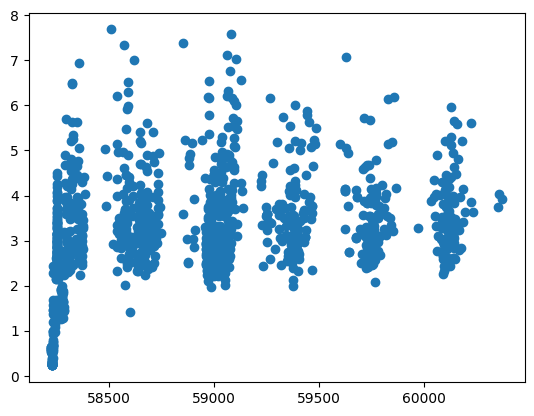

In [4]:
fig, ax = plt.subplots()
ax.scatter(lc_dict['ZTF18aakuewf'].mjd, lc_dict['ZTF18aakuewf'].mag*lc_dict['ZTF18aakuewf'].magerr)

Compile all the objects into one dataframe, with the following columns:
- `id`: the object id
- `class`: the object class
- `redshift`: the redshift of the object
- `mjd`: time of observation
- `mag`: the magnitude of the object
- `mag_err`: the error of the magnitude
- `filter`: the filter of the observation

In [5]:
df_objects = pd.DataFrame(columns=['obj_id', 'type', 'redshift', 'mjd', 'mag', 'magerr', 'filter', 'snr'])

for obj_id in objIds:
    df_lc = lc_dict[obj_id]
    df_lc.dropna(subset=['mag', 'magerr'], inplace=True)
    df_lc['id'] = obj_id
    df_lc = df_lc[['obj_id', 'mjd', 'mag', 'magerr', 'filter', 'snr']]
    df_lc['type'] = df_eval.loc[df_eval['object'] == obj_id, 'class'].values[0]
    df_lc['redshift'] = df_eval.loc[df_eval['object'] == obj_id, 'redshift'].values[0]
    df_objects = pd.concat([df_objects, df_lc])

/tmp/ipykernel_47568/982688885.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lc['type'] = df_eval.loc[df_eval['object'] == obj_id, 'class'].values[0]
/tmp/ipykernel_47568/982688885.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lc['redshift'] = df_eval.loc[df_eval['object'] == obj_id, 'redshift'].values[0]
/tmp/ipykernel_47568/982688885.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

In [6]:
df_objects = df_objects[(df_objects['filter'] == 'ztfr') | (df_objects['filter'] == 'ztfg') | (df_objects['filter'] == 'ztfi')]
df_objects = df_objects[df_objects['snr']>5]

In [7]:
def Mag2Flux(df):
    df_copy = df.dropna().copy()
    df_copy['flux'] = 10 ** (-0.4 * (df_copy['mag'] - 23.9))
    df_copy['flux_error'] = (df_copy['magerr'] / (2.5 / np.log(10))) * df_copy['flux']

    df_copy = df_copy[['obj_id', 'mjd', 'flux', 'flux_error', 'filter', 'type', 'redshift']]
    return df_copy

def Normalize(df):
    df_copy = df.dropna().copy()
    df_copy['mjd_0'] = df_copy.groupby('obj_id')['mjd'].transform(lambda x: np.min(x))
    df_copy['mjd'] = df_copy.groupby('obj_id')['mjd'].transform(lambda x: x - np.min(x))

    df_copy.reset_index(drop=True, inplace=True)
    return df_copy


In [8]:
flux_df = Mag2Flux(df_objects)
flux_df = flux_df.dropna(subset=['flux', 'flux_error']).copy()
norm_df = Normalize(flux_df)


In [9]:
norm_df

obj_id       mjd        flux  flux_error filter type redshift  \
0     ZTF18aakuewf  0.000000   94.536566    2.762427   ztfr  Ibn   0.0636   
1     ZTF18aakuewf  0.018090  102.621835    2.780158   ztfr  Ibn   0.0636   
2     ZTF18aakuewf  0.038414   97.921932    3.020715   ztfr  Ibn   0.0636   
3     ZTF18aakuewf  0.073924  104.087781    3.031263   ztfr  Ibn   0.0636   
4     ZTF18aakuewf  0.074861  104.761025    3.220689   ztfr  Ibn   0.0636   
...            ...       ...         ...         ...    ...  ...      ...   
5864  ZTF24aascytf  3.190382   26.859287    3.875425   ztfg   II    0.038   
5865  ZTF24aascytf  5.136296   25.594688    4.422032   ztfr   II    0.038   
5866  ZTF24aascytf  9.123403   35.998116    6.552586   ztfr   II    0.038   
5867  ZTF24aascytf  9.123403   35.998749    6.552715   ztfr   II    0.038   
5868  ZTF24aascytf  9.123403   36.231281    4.404822   ztfr   II    0.038   

             mjd_0  
0     58226.340532  
1     58226.340532  
2     58226.340532  
3     58226.340532  
4     58226.340532  
...            ...  
5864  60476.217836  
5865  60476.217836  
5866  60476.217836  
5867  60476.217836  
5868  60476.217836  

[5869 rows x 8 columns]

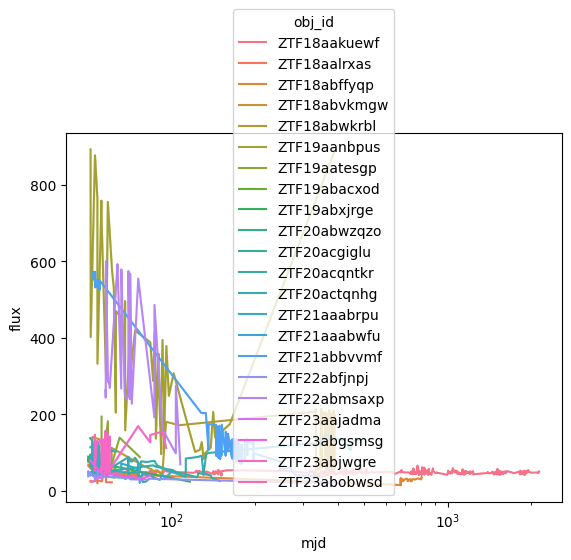

In [10]:
fig, ax = plt.subplots()
sns.lineplot(data=norm_df[norm_df['mjd']>50], x='mjd', y='flux', hue='obj_id', ax=ax)
ax.set_xscale('log')

/tmp/ipykernel_47568/4024913305.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.lineplot(data=norm_df[norm_df['obj_id'].isin(long_objects)][norm_df['mjd']<50][norm_df['obj_id']!='ZTF22abfjnpj'], x='mjd', y='flux', hue='obj_id', ax=ax)


<Axes: xlabel='mjd', ylabel='flux'>

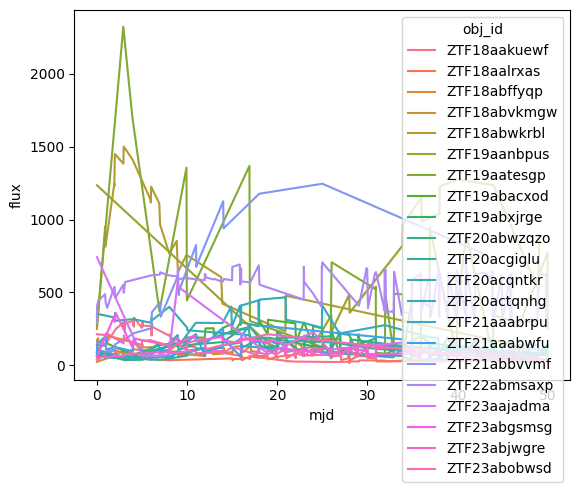

In [11]:
long_objects = norm_df[norm_df.groupby('obj_id')['mjd'].transform('max') > 50]['obj_id'].unique()

fig, ax = plt.subplots()
sns.lineplot(data=norm_df[norm_df['obj_id'].isin(long_objects)][norm_df['mjd']<50][norm_df['obj_id']!='ZTF22abfjnpj'], x='mjd', y='flux', hue='obj_id', ax=ax)

In [12]:
def count_obj_by_type(df):
    obj_id_count_per_type = df.groupby('type')['obj_id'].nunique()
    print(obj_id_count_per_type)

In [13]:
from sklearn.model_selection import GroupShuffleSplit

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

train_idx, test_idx = next(gss.split(norm_df, groups=norm_df['obj_id']))

train_data = norm_df.iloc[train_idx]
test_data = norm_df.iloc[test_idx]

In [14]:
count_obj_by_type(train_data)
count_obj_by_type(test_data)

type
Cataclysmic                9
FBOT                       2
GRB                        1
II                         6
IIP                        1
IIb                       14
Ia                         3
Ib                         3
Ib/c;Ib-pec                1
Ibn                        2
Novae                      3
Novae;Classical Nova       4
Tidal Disruption Event     1
U Gem                      1
afterglow                  2
afterglow; Ic-BL           1
long GRB                   4
Name: obj_id, dtype: int64
type
Cataclysmic         1
II                  2
IIb                 6
Ia                  2
Ibn                 1
Ic-BL               1
Novae               1
afterglow; Ic-BL    1
Name: obj_id, dtype: int64


In [15]:
pb_wavelengths = {
    'ztfg': 4800.,
    'ztfr': 6400.,
    'ztfi': 7900.,
}

filters = ['ztfg', 'ztfr', 'ztfi']

gp_wavelengths = np.vectorize(pb_wavelengths.get)(filters)

inverse_gp_wavelengths = {v: k for k, v in pb_wavelengths.items()}

# These functions are taken from the 'Paying Attention to Astronomical Transients' paper

def fit_2d_gp(obj_data, kernel=None, return_kernel=False, global_fit=False, **kwargs):
    if kernel is None:
        guess_length_scale = 20.0
        signal_to_noises = np.abs(obj_data.flux) / np.sqrt(
            obj_data.flux_error ** 2 + (1e-2 * np.max(obj_data.flux)) ** 2
        )
        scale = np.abs(obj_data.flux[signal_to_noises.idxmax()])
        kernel = (0.5 * scale) ** 2 * george.kernels.Matern32Kernel([
            guess_length_scale ** 2, 6000 ** 2], ndim=2)
        kernel.freeze_parameter("k2:metric:log_M_1_1")


    obj_times = obj_data.mjd.astype(float)
    obj_flux = obj_data.flux.astype(float)
    obj_flux_error = obj_data.flux_error.astype(float)
    obj_wavelengths = obj_data['filter'].map(pb_wavelengths)

    def neg_log_like(p):  # Objective function: negative log-likelihood
        gp.set_parameter_vector(p)
        loglike = gp.log_likelihood(obj_flux, quiet=True)
        return -loglike if np.isfinite(loglike) else 1e25

    def grad_neg_log_like(p):  # Gradient of the objective function.
        gp.set_parameter_vector(p)
        return -gp.grad_log_likelihood(obj_flux, quiet=True)

    gp = george.GP(kernel)
    default_gp_param = gp.get_parameter_vector()
    x_data = np.vstack([obj_times, obj_wavelengths]).T
    gp.compute(x_data, obj_flux_error)

    bounds = [(0, np.log(1000 ** 2))]
    bounds = [(default_gp_param[0] - 10, default_gp_param[0] + 10)] + bounds
    results = op.minimize(neg_log_like, gp.get_parameter_vector(),
                          jac=grad_neg_log_like, method="L-BFGS-B",
                          bounds=bounds, tol=1e-6)

    if results.success:
        gp.set_parameter_vector(results.x)
    else:
        # Fit failed. Print out a warning, and use the initial guesses for fit
        # parameters.
        obj = obj_data['obj_id'][0]
        print("GP fit failed for {}! Using guessed GP parameters.".format(obj))
        gp.set_parameter_vector(default_gp_param)

    gp_predict = partial(gp.predict, obj_flux)

    if return_kernel:
        return kernel, gp_predict
    else:
        return gp_predict


def predict_2d_gp(gp_predict, gp_times, gp_wavelengths):
    """Outputs the predictions of a Gaussian Process.

    Parameters
    ----------
    gp_predict : functools.partial of george.gp.GP
        The GP instance that was used to fit the object.
    gp_times : numpy.ndarray
        Times to evaluate the Gaussian Process at.
    gp_wavelengths : numpy.ndarray
        Wavelengths to evaluate the Gaussian Process at.

    Returns
    -------
    obj_gps : pandas.core.frame.DataFrame, optional
        Time, flux and flux error of the fitted Gaussian Process.
    """
    unique_wavelengths = np.unique(gp_wavelengths)
    number_gp = len(gp_times)
    obj_gps = []
    for wavelength in unique_wavelengths:
        gp_wavelengths = np.ones(number_gp) * wavelength
        pred_x_data = np.vstack([gp_times, gp_wavelengths]).T
        pb_pred, pb_pred_var = gp_predict(pred_x_data, return_var=True)
        # stack the GP results in a array momentarily
        obj_gp_pb_array = np.column_stack((gp_times, pb_pred, np.sqrt(pb_pred_var)))
        obj_gp_pb = Table(
            [
                obj_gp_pb_array[:, 0],
                obj_gp_pb_array[:, 1],
                obj_gp_pb_array[:, 2],
                [wavelength] * number_gp,
            ],
            names=["mjd", "flux", "flux_error", "filter"],
        )
        if len(obj_gps) == 0:  # initialize the table for 1st passband
            obj_gps = obj_gp_pb
        else:  # add more entries to the table
            obj_gps = vstack((obj_gps, obj_gp_pb))
            
    obj_gps = obj_gps.to_pandas()
    return obj_gps

def process_gaussian(df, kernel=None, number_gp=100, save=False, name=''):
    
    res_df = pd.DataFrame()

    for obj_id in tqdm.tqdm(df['obj_id'].unique()):
        obj_df = df[df['obj_id'] == obj_id]
        type_obj = obj_df['type'].values[0]
        mjd_0 = obj_df['mjd_0'].values[0]
        redshift = obj_df['redshift'].values[0]
        obj_df.reset_index(drop=True, inplace=True)

        available_filters = obj_df['filter'].unique()
        gp_wavelengths = np.vectorize(pb_wavelengths.get)(available_filters)
        inverse_gp_wavelengths = {v: k for k, v in pb_wavelengths.items() if k in available_filters}
        gp_predict = fit_2d_gp(obj_df, kernel=kernel)
        gp_times = np.linspace(min(obj_df['mjd']), max(obj_df['mjd']), number_gp)

        obj_gps = predict_2d_gp(gp_predict, gp_times, gp_wavelengths)
        obj_gps['filter'] = obj_gps['filter'].map(inverse_gp_wavelengths)

        obj_gps = obj_gps.pivot_table(index=['mjd'], columns='filter', values=['flux', 'flux_error'])
        obj_gps = obj_gps.reset_index()
        obj_gps.columns = [col[0] if col[0] == 'mjd' else '_'.join(col).strip() for col in obj_gps.columns.values]
        obj_gps['type'] = type_obj
        obj_gps['obj_id'] = obj_id
        obj_gps['mjd_0'] = mjd_0
        obj_gps['redshift'] = redshift

        res_df = pd.concat([res_df, obj_gps])

    res_df.reset_index(drop=True, inplace=True)

    if save:
        #types_str = '_'.join(df['type'].unique()) if hasattr(df['type'].unique(), '__iter__') else str(df['type'].unique())
        #filename = f'{name}_gp_{types_str}.csv'
        num_types_str = str(len(df['type'].unique()))
        filename = f'{name}_gp_n{num_types_str}.csv'
        filename = filename.replace(' ', '_')
        res_df.to_csv(filename, index=False)
        print(f'File {filename} saved successfully')
    return res_df

def save_kernel(kernel, filename):
    with open(filename, 'wb') as f:
        pickle.dump(kernel, f)
    print(f'Kernel saved to {filename}')

def load_kernel(filename):
    with open(filename, 'rb') as f:
        kernel = pickle.load(f)
    print(f'Kernel loaded from {filename}')
    return kernel

In [16]:
kernel = load_kernel('kernel.pkl')

Kernel loaded from kernel.pkl


In [43]:
# test_results = process_gaussian(test_data, kernel=kernel, save=True, name='test')
# train_results = process_gaussian(train_data, kernel=kernel, save=True, name='train')
total_results = process_gaussian(norm_df[norm_df['mjd']<50], kernel=kernel, save=False, name='total', number_gp=1000)

100%|██████████| 73/73 [00:05<00:00, 14.52it/s]


In [44]:
total_results[total_results['obj_id'] == 'ZTF18aakuewf']


mjd   flux_ztfg   flux_ztfr  flux_error_ztfg  flux_error_ztfr type  \
0     0.000000  136.473151   99.008321        20.223566         1.245737  Ibn   
1     0.049981  139.022248  101.683596        19.834904         1.079511  Ibn   
2     0.099961  141.589596  104.383825        19.445064         1.085820  Ibn   
3     0.149942  144.174698  107.090648        19.053877         1.235566  Ibn   
4     0.199923  146.777048  109.794837        18.661182         1.460953  Ibn   
..         ...         ...         ...              ...              ...  ...   
995  49.730749   44.108819   41.294699         2.906752        37.457428  Ibn   
996  49.780729   44.119815   41.276259         2.897688        37.491600  Ibn   
997  49.830710   44.128496   41.256129         2.919293        37.528617  Ibn   
998  49.880691   44.134229   41.234302         2.984577        37.568651  Ibn   
999  49.930671   44.136378   41.210767         3.105638        37.611877  Ibn   

           obj_id         mjd_0 redshift  flux_ztfi  flux_error_ztfi  
0    ZTF18aakuewf  58226.340532   0.0636        NaN              NaN  
1    ZTF18aakuewf  58226.340532   0.0636        NaN              NaN  
2    ZTF18aakuewf  58226.340532   0.0636        NaN              NaN  
3    ZTF18aakuewf  58226.340532   0.0636        NaN              NaN  
4    ZTF18aakuewf  58226.340532   0.0636        NaN              NaN  
..            ...           ...      ...        ...              ...  
995  ZTF18aakuewf  58226.340532   0.0636        NaN              NaN  
996  ZTF18aakuewf  58226.340532   0.0636        NaN              NaN  
997  ZTF18aakuewf  58226.340532   0.0636        NaN              NaN  
998  ZTF18aakuewf  58226.340532   0.0636        NaN              NaN  
999  ZTF18aakuewf  58226.340532   0.0636        NaN              NaN  

[1000 rows x 11 columns]

In [45]:
color_dict = {'ztfg': 'green', 'ztfr': 'red', 'ztfi': 'yellow'}
def plot_gp(obj_model, number_col=4, show_title=True, show_legend=True):
    color_dict = {'ztfg': 'green', 'ztfr': 'red', 'ztfi': 'yellow'}
    f, ax = plt.subplots(figsize=(10, 6))
    ax.set_xlabel('Time (mjd)')
    ax.set_ylabel('Flux') 
    if show_title:
        obj_id = obj_model['obj_id'].iloc[0]
        ax.set_title(f'Light Curve for Object ID: {obj_id} | Type: {obj_model["type"].iloc[0]}')
    if show_legend:
        ax.legend(ncol=number_col)

    # Plotting model data if available
    if obj_model is not None:
        # Iterate over the filters present in the obj_model DataFrame
        for column in obj_model.columns:
            if 'flux' in column and column != 'mjd':
                filter_name = column.split('_')[1]
                if filter_name in color_dict:
                    if not all(obj_model[column] == -1):
                        ax.plot(obj_model['mjd'], obj_model[column], label=f'Model {filter_name}', color=color_dict[filter_name])
    
                        # Plot error band if error data is available
                        error_column = f'flux_error_{filter_name}'
                        if error_column in obj_model.columns:
                            model_flux_error = obj_model[error_column]
                            ax.fill_between(obj_model['mjd'], obj_model[column]-model_flux_error, obj_model[column]+model_flux_error, color=color_dict[filter_name], alpha=0.20)

    return f,ax

In [46]:
total_results

mjd   flux_ztfg   flux_ztfr  flux_error_ztfg  flux_error_ztfr  \
0      0.000000  136.473151   99.008321        20.223566         1.245737   
1      0.049981  139.022248  101.683596        19.834904         1.079511   
2      0.099961  141.589596  104.383825        19.445064         1.085820   
3      0.149942  144.174698  107.090648        19.053877         1.235566   
4      0.199923  146.777048  109.794837        18.661182         1.460953   
...         ...         ...         ...              ...              ...   
71996  9.086873   33.104947   36.051876        20.273348         3.441576   
71997  9.096005   33.093513   36.039692        20.264562         3.332267   
71998  9.105138   33.081261   36.026243        20.258811         3.251571   
71999  9.114270   33.068191   36.011512        20.256105         3.202154   
72000  9.123403   33.054302   35.995481        20.256452         3.185979   

      type        obj_id         mjd_0 redshift  flux_ztfi  flux_error_ztfi  
0      Ibn  ZTF18aakuewf  58226.340532   0.0636        NaN              NaN  
1      Ibn  ZTF18aakuewf  58226.340532   0.0636        NaN              NaN  
2      Ibn  ZTF18aakuewf  58226.340532   0.0636        NaN              NaN  
3      Ibn  ZTF18aakuewf  58226.340532   0.0636        NaN              NaN  
4      Ibn  ZTF18aakuewf  58226.340532   0.0636        NaN              NaN  
...    ...           ...           ...      ...        ...              ...  
71996   II  ZTF24aascytf  60476.217836    0.038  33.927364        19.254350  
71997   II  ZTF24aascytf  60476.217836    0.038  33.912465        19.244562  
71998   II  ZTF24aascytf  60476.217836    0.038  33.896745        19.238097  
71999   II  ZTF24aascytf  60476.217836    0.038  33.880203        19.234967  
72000   II  ZTF24aascytf  60476.217836    0.038  33.862840        19.235181  

[72001 rows x 11 columns]

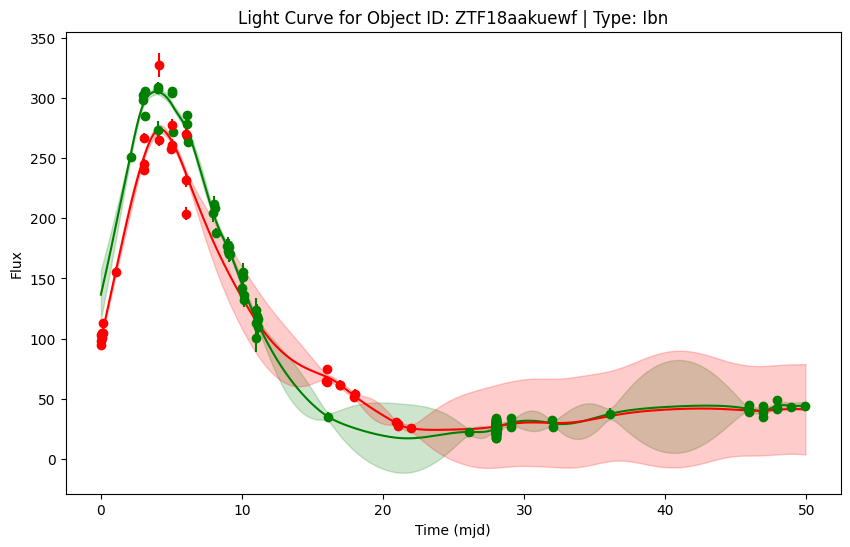

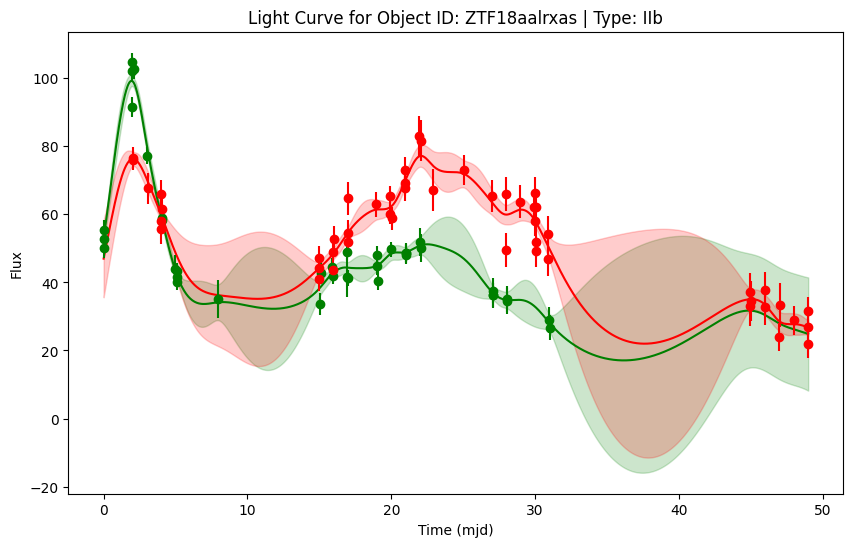

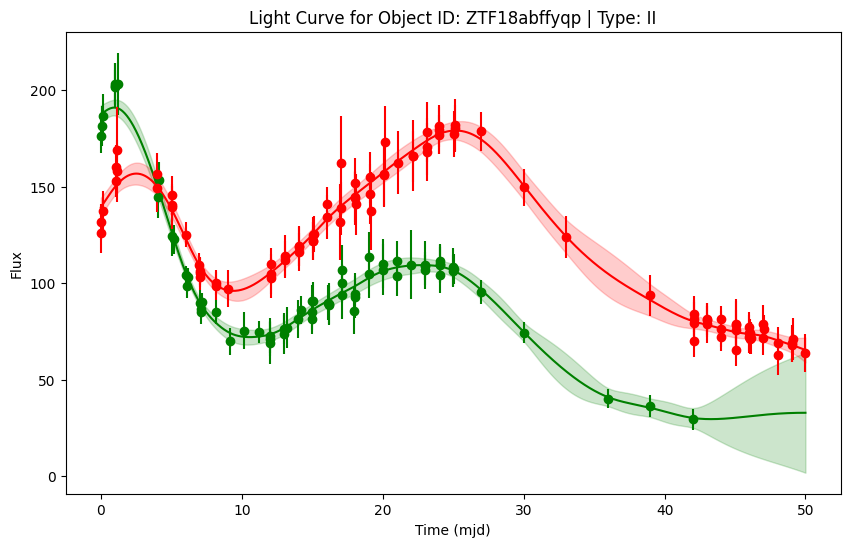

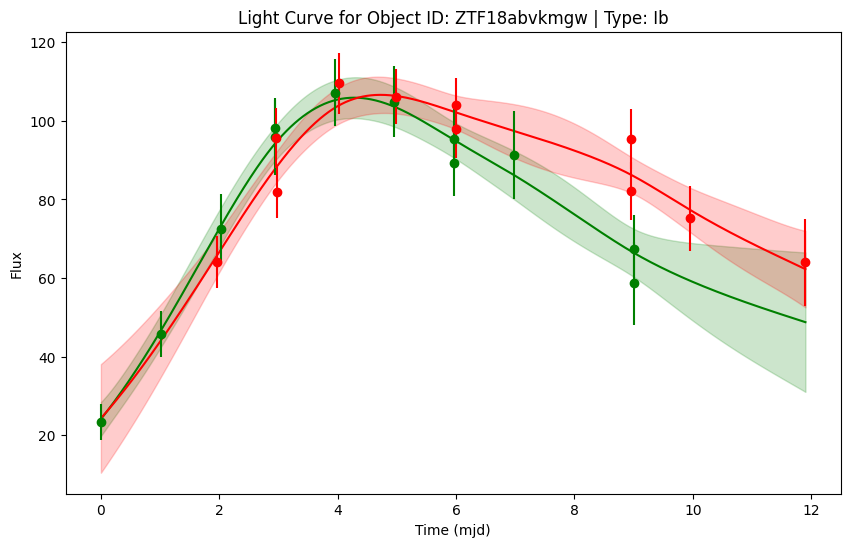

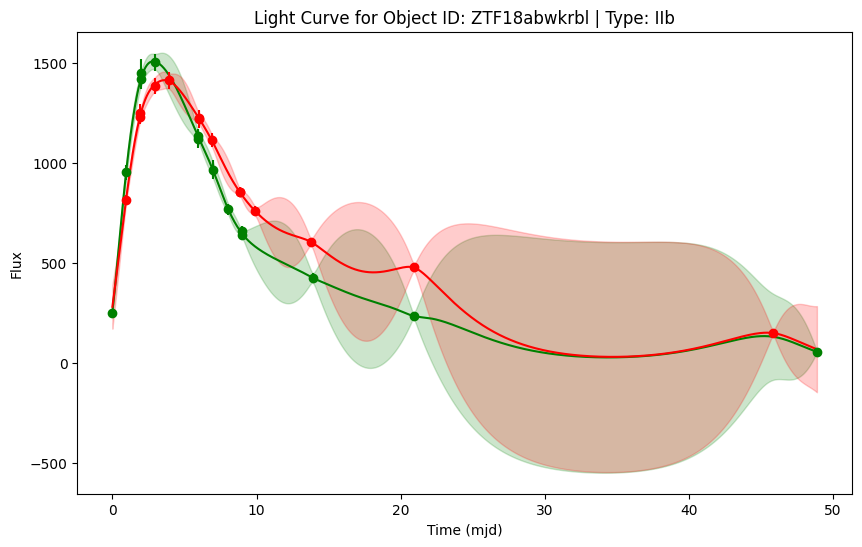

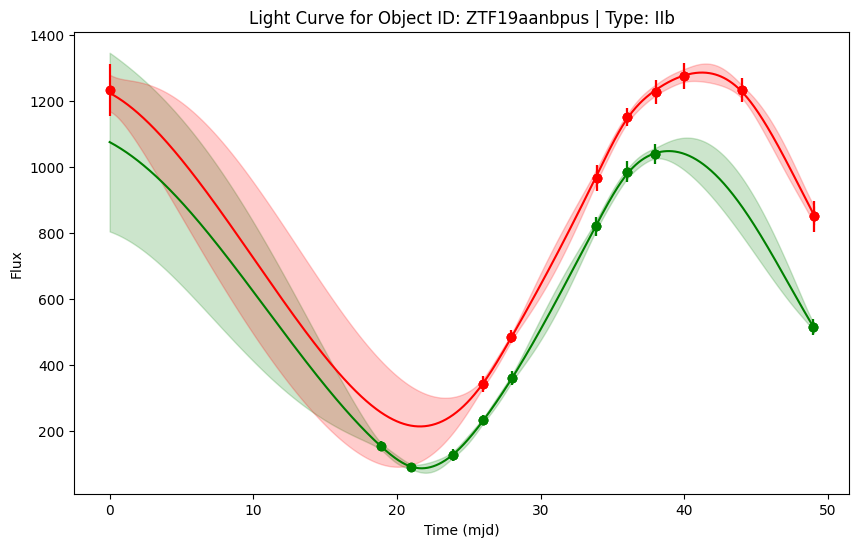

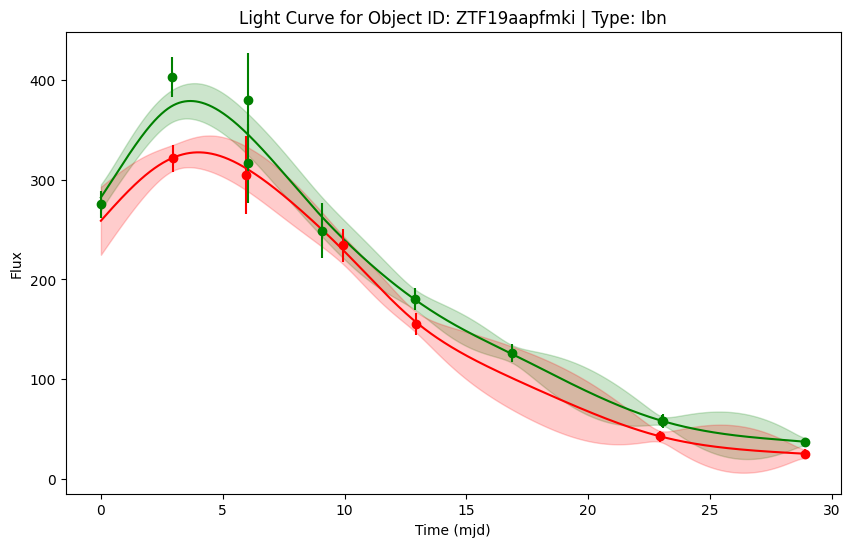

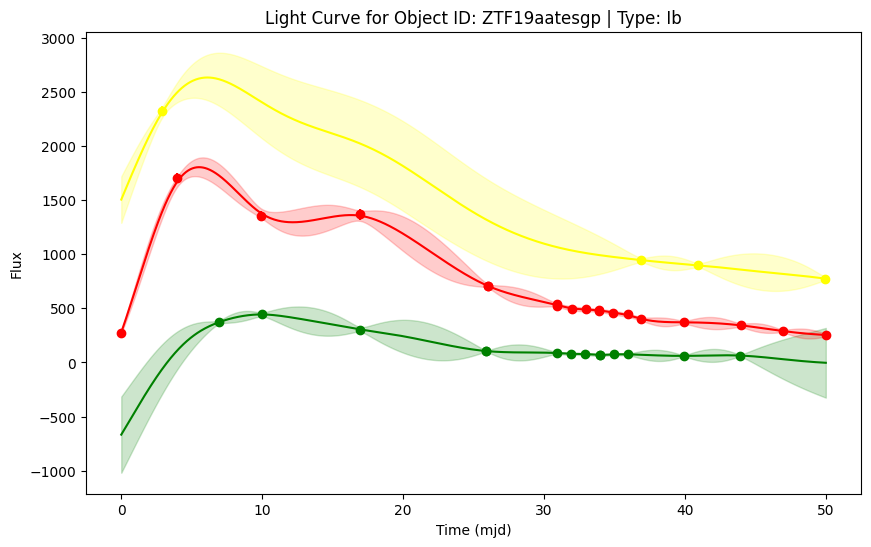

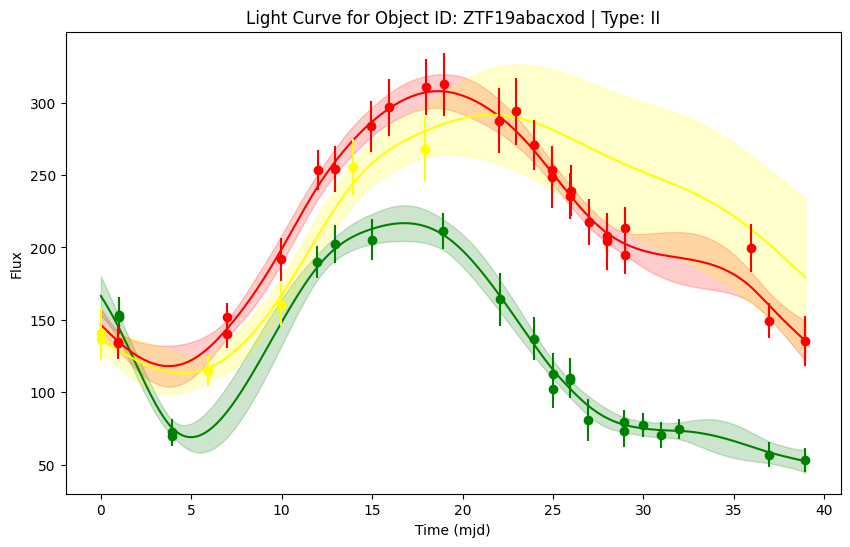

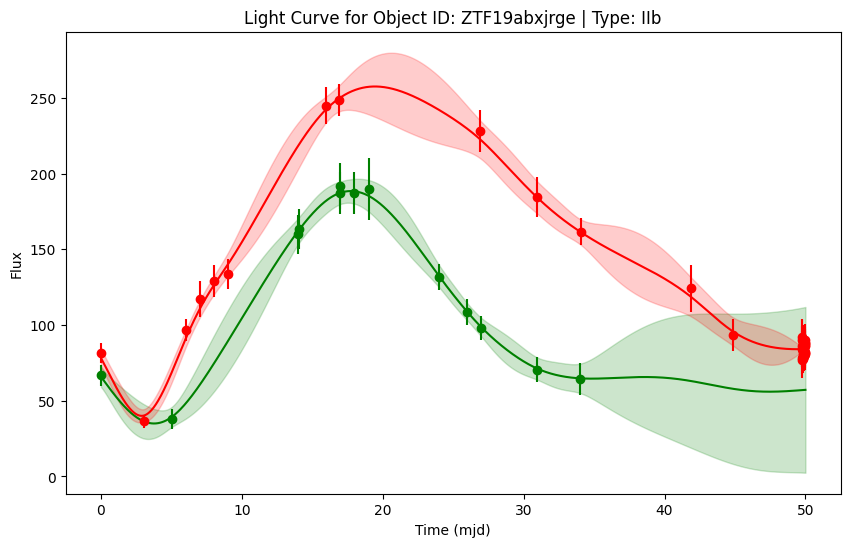

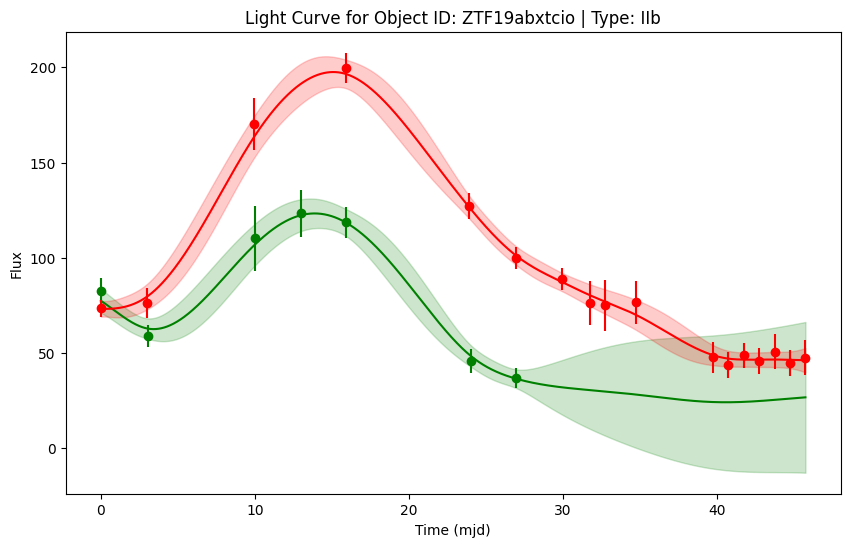

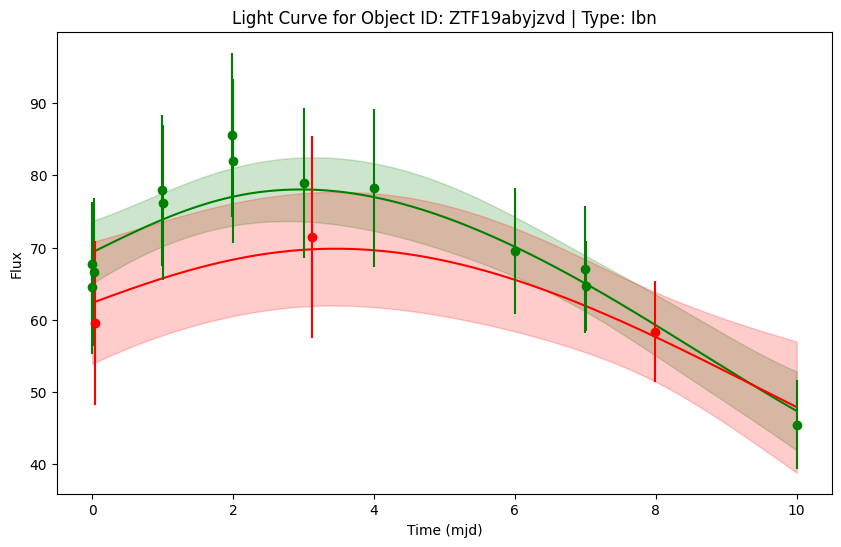

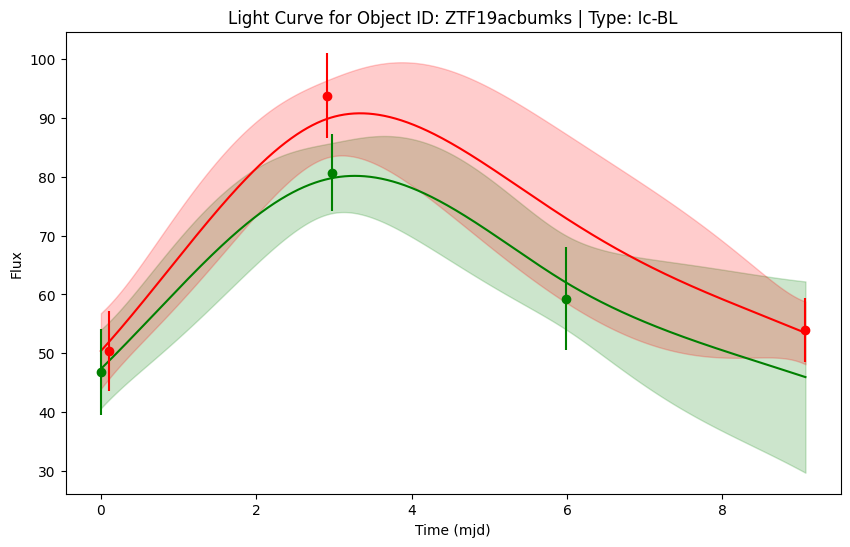

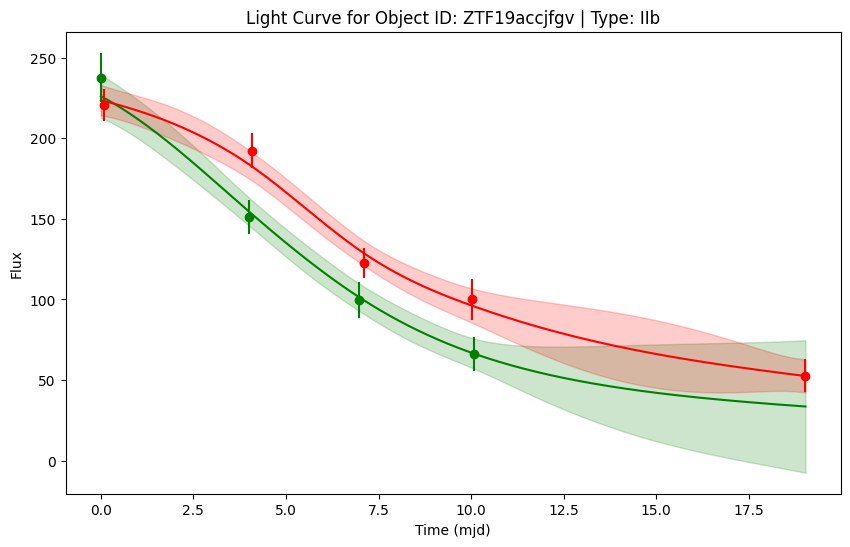

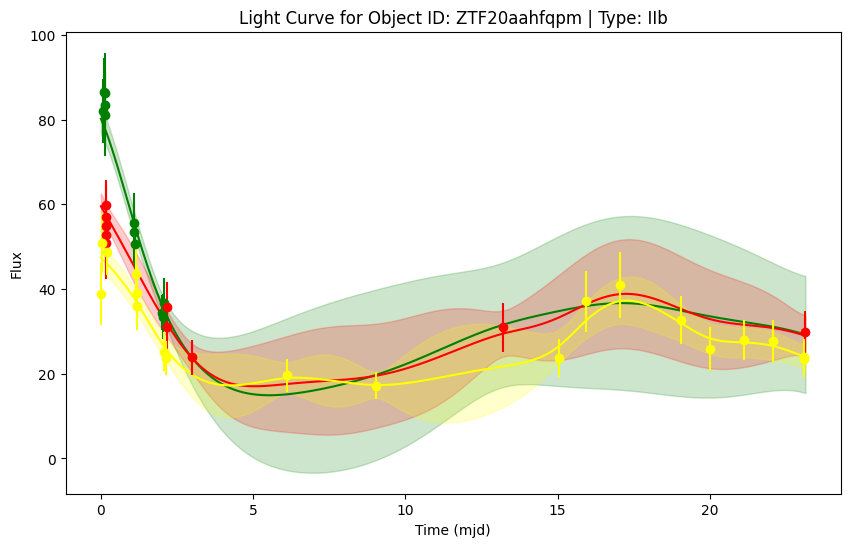

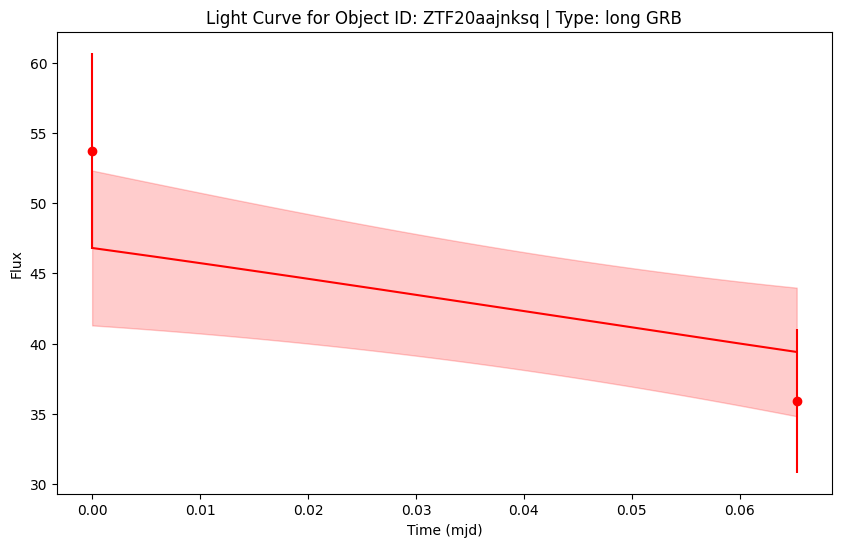

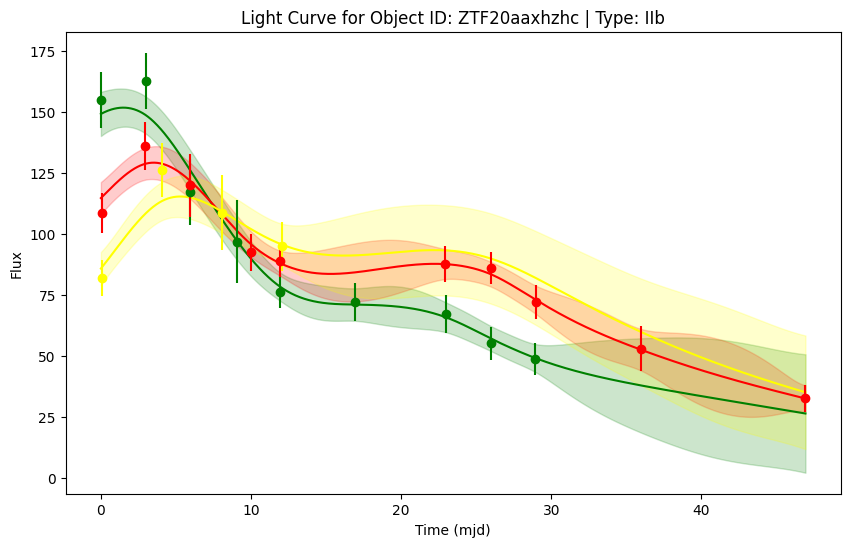

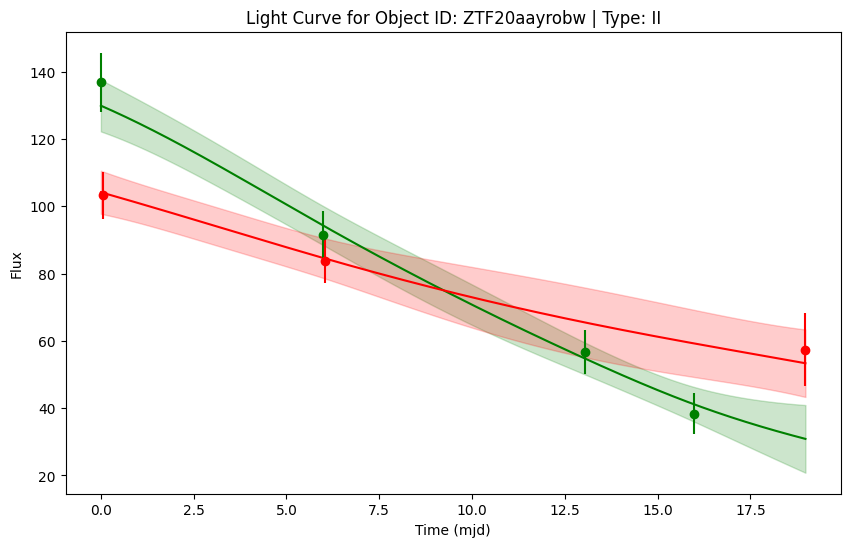

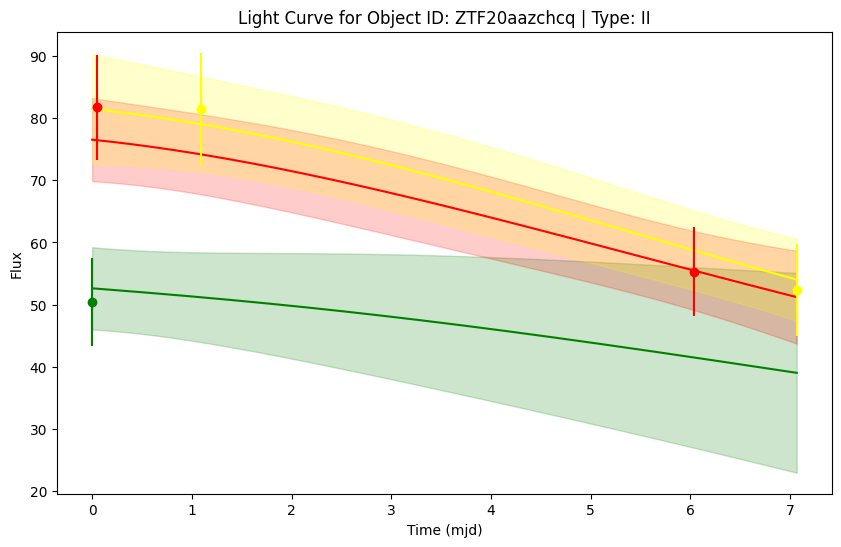

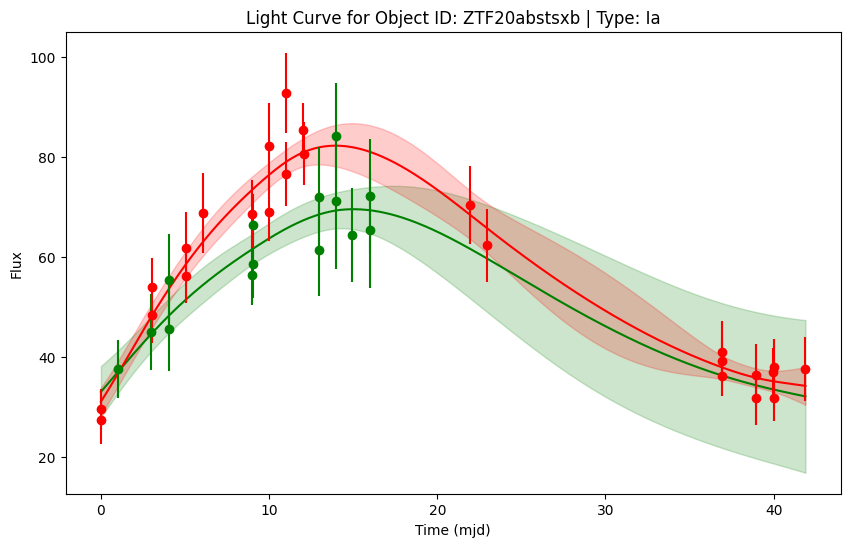

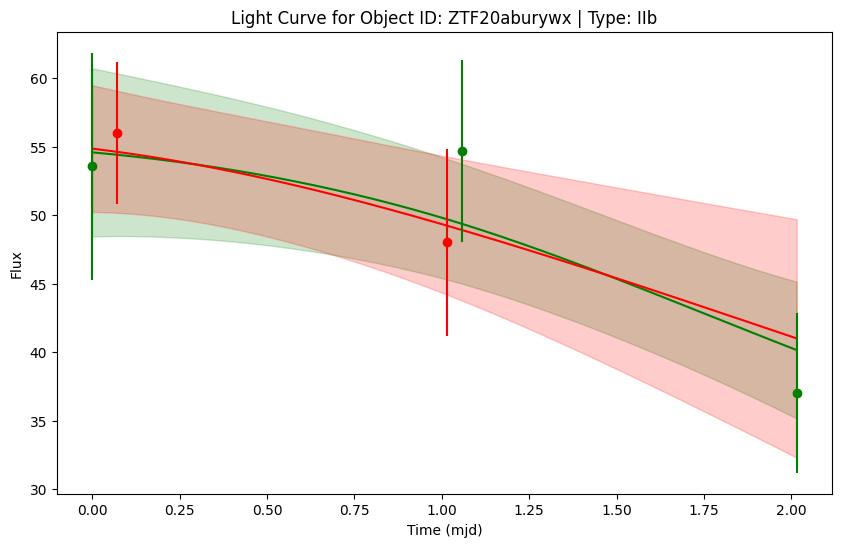

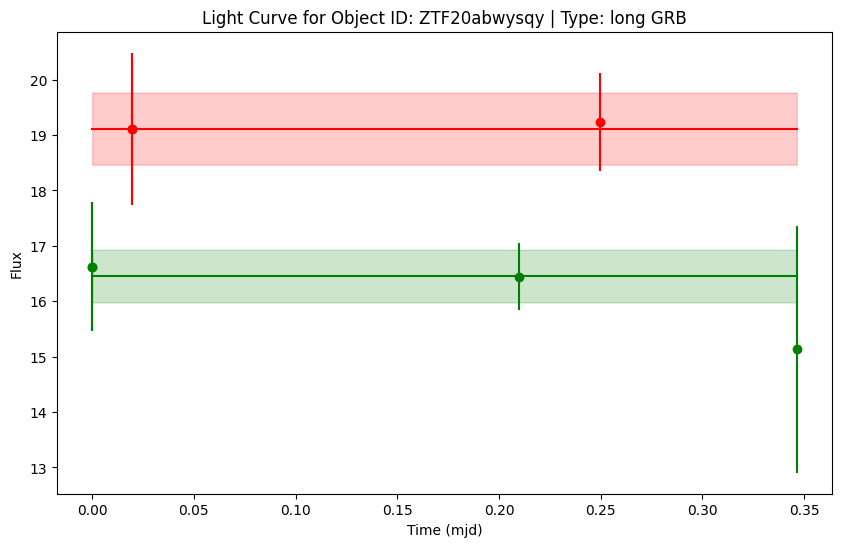

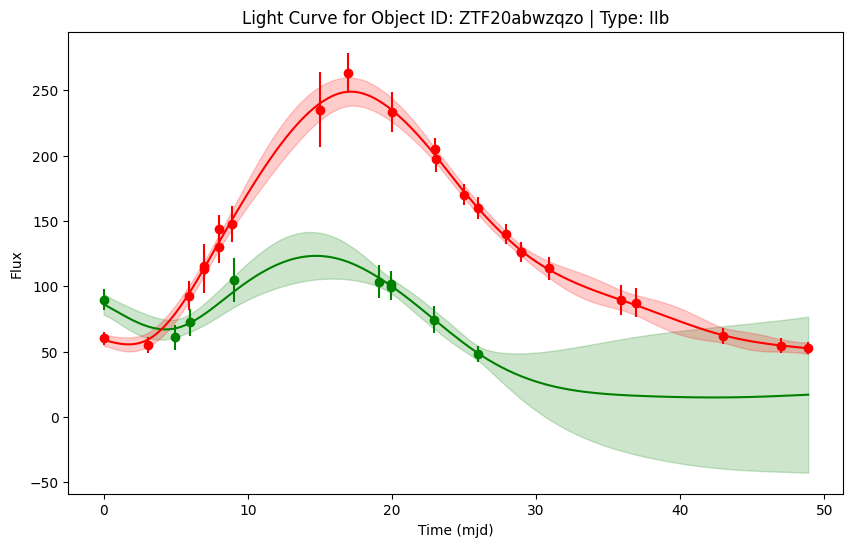

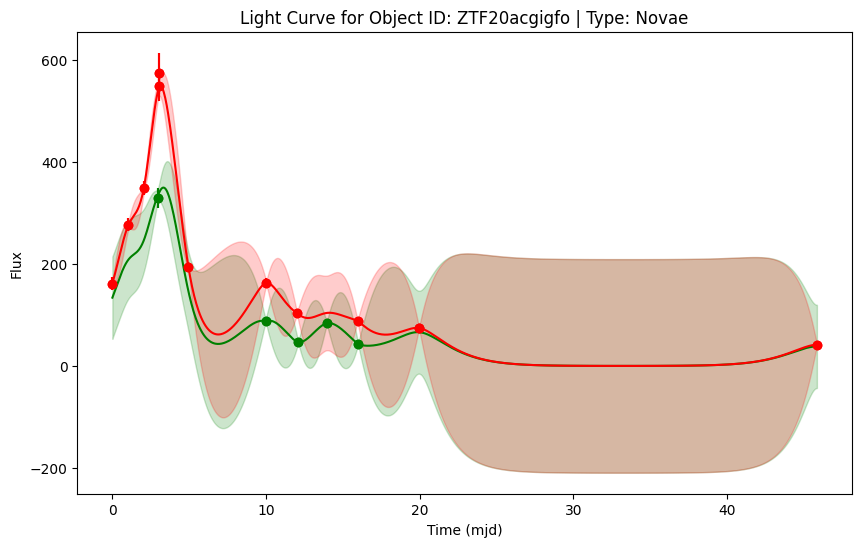

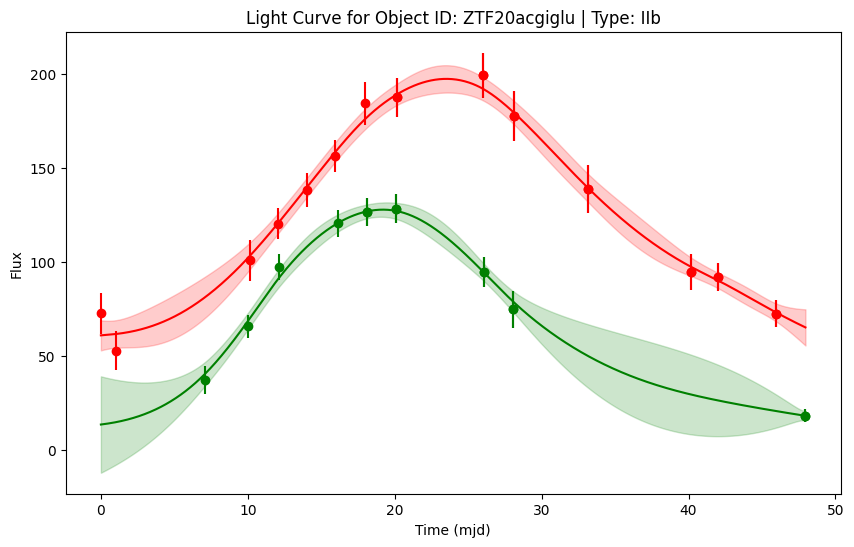

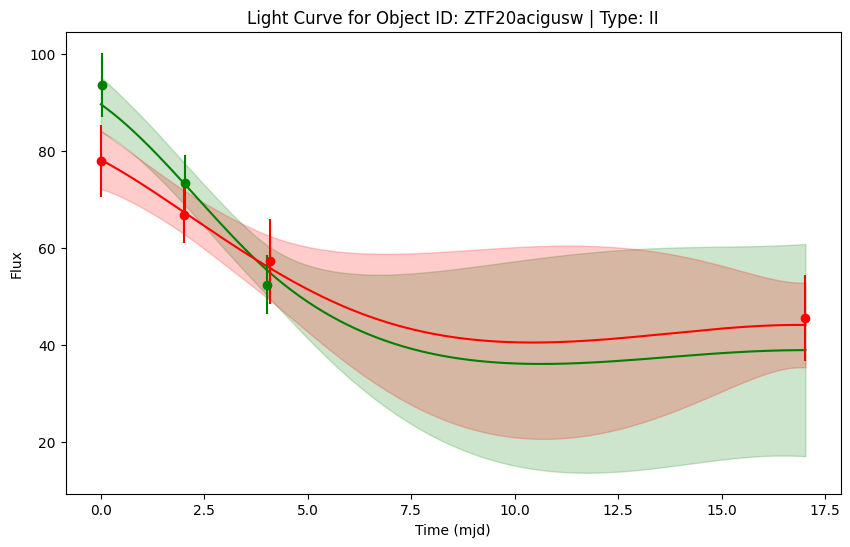

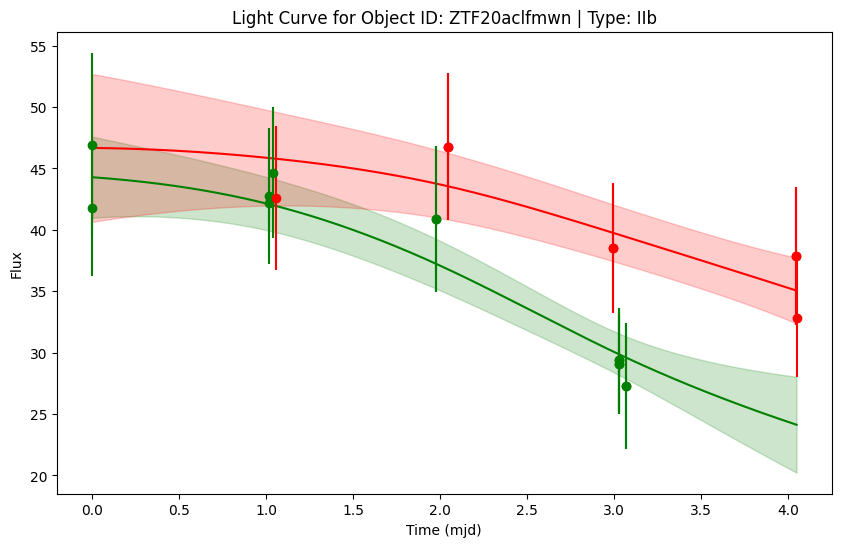

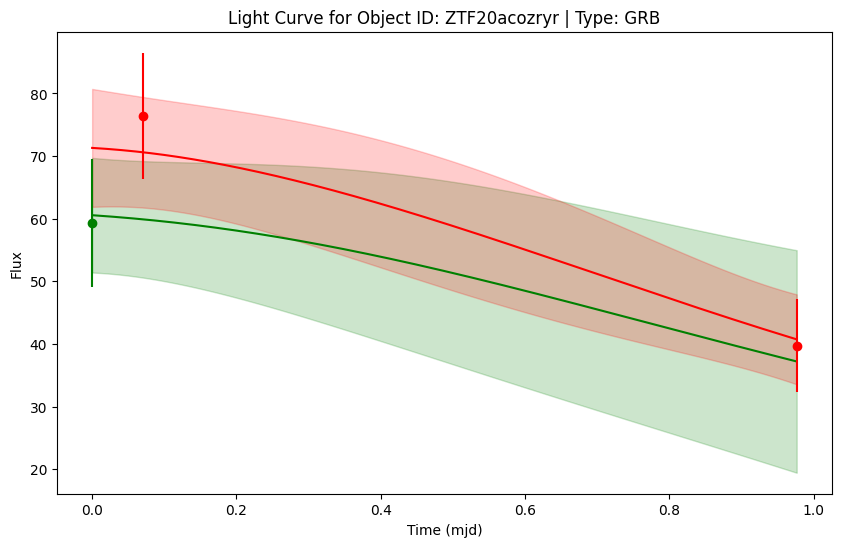

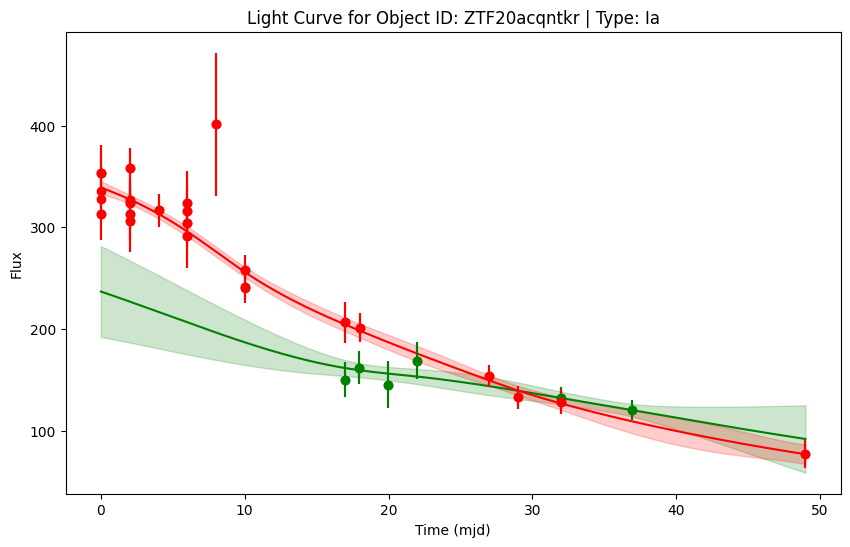

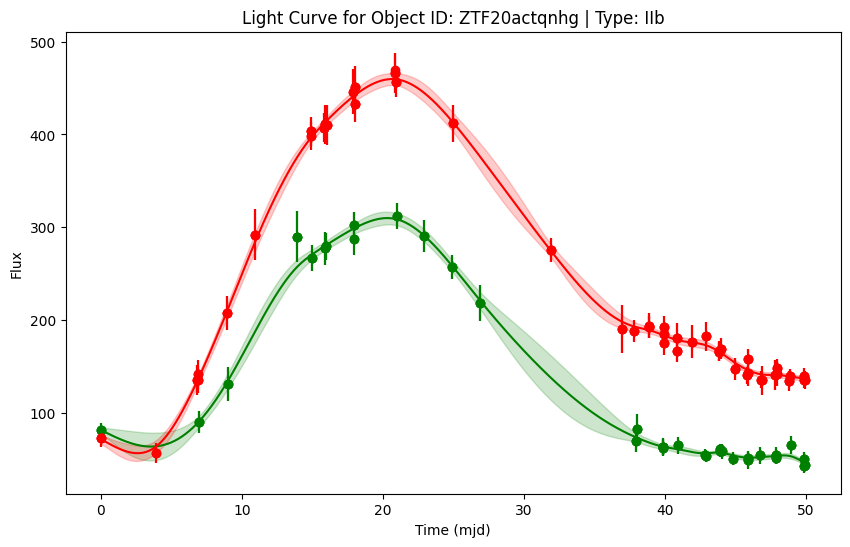

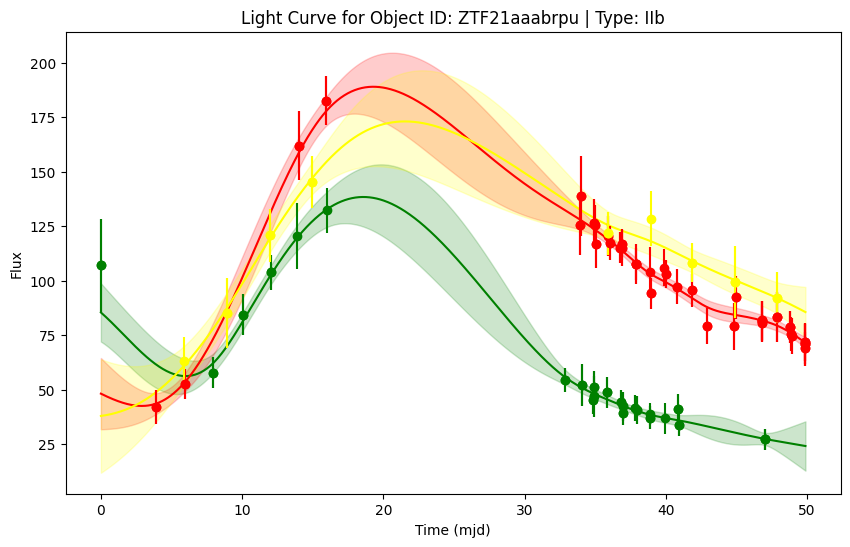

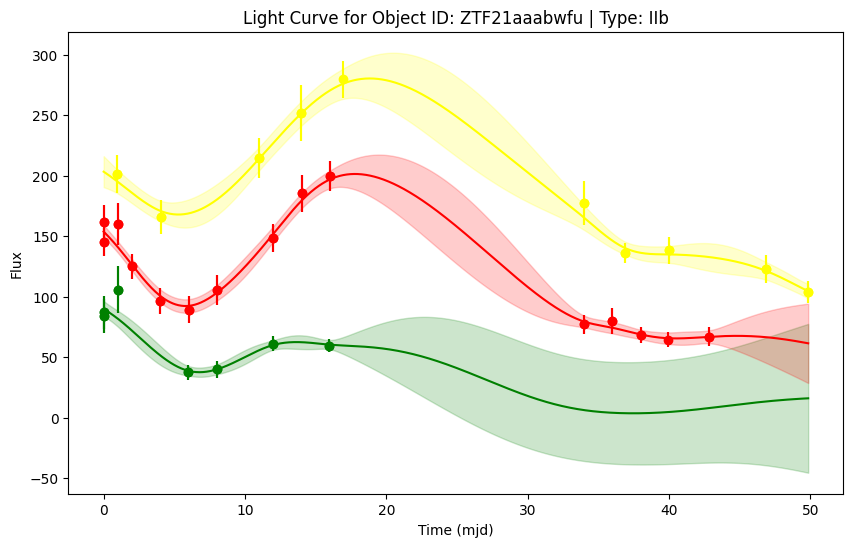

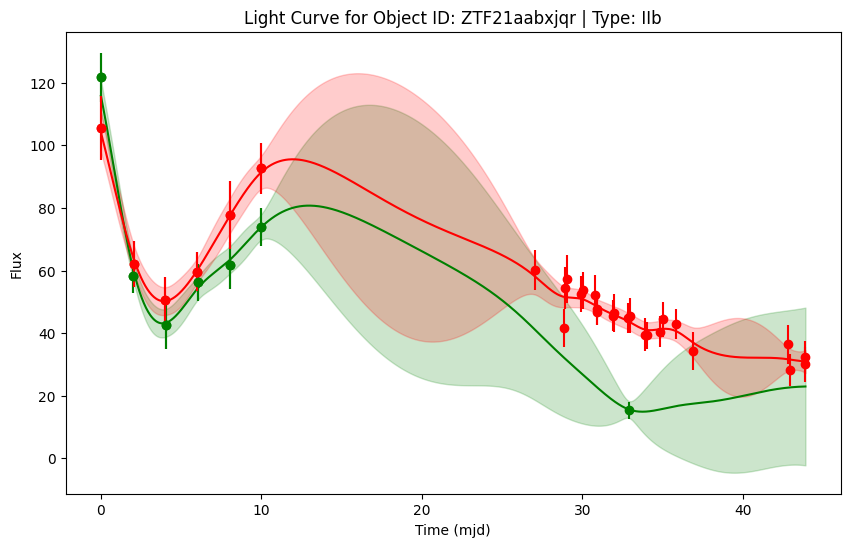

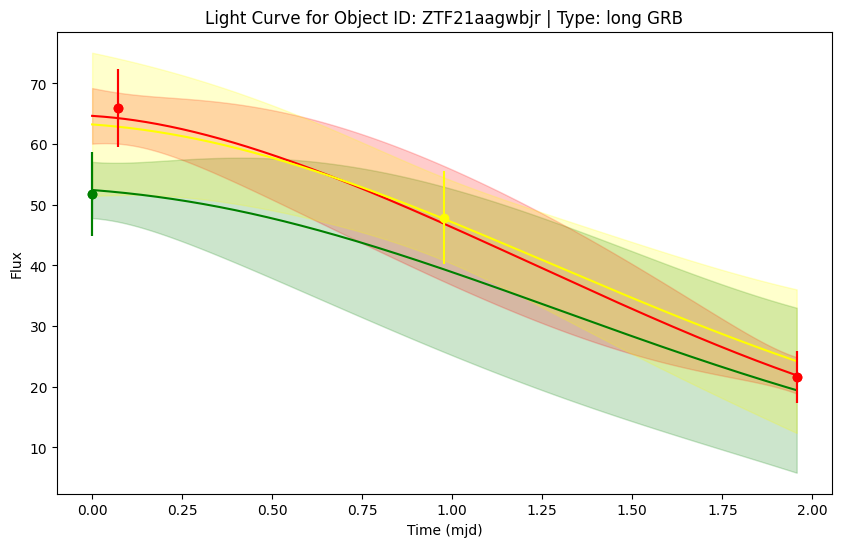

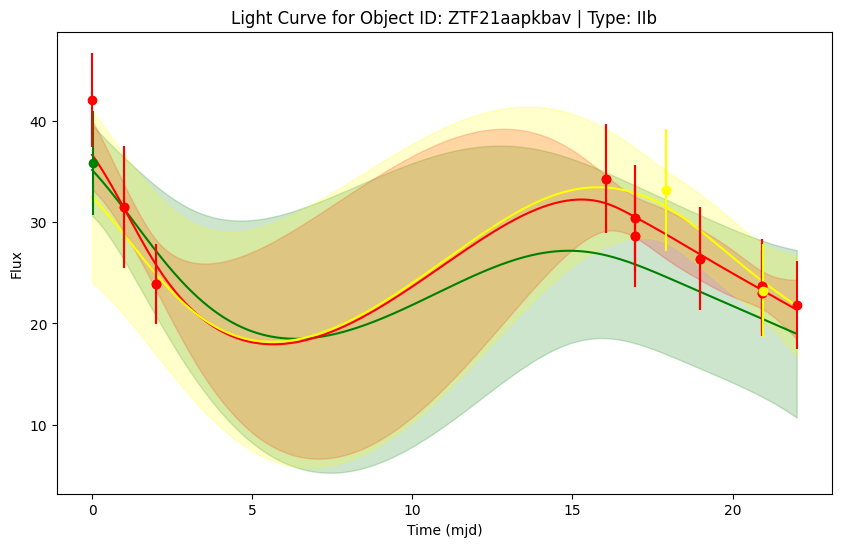

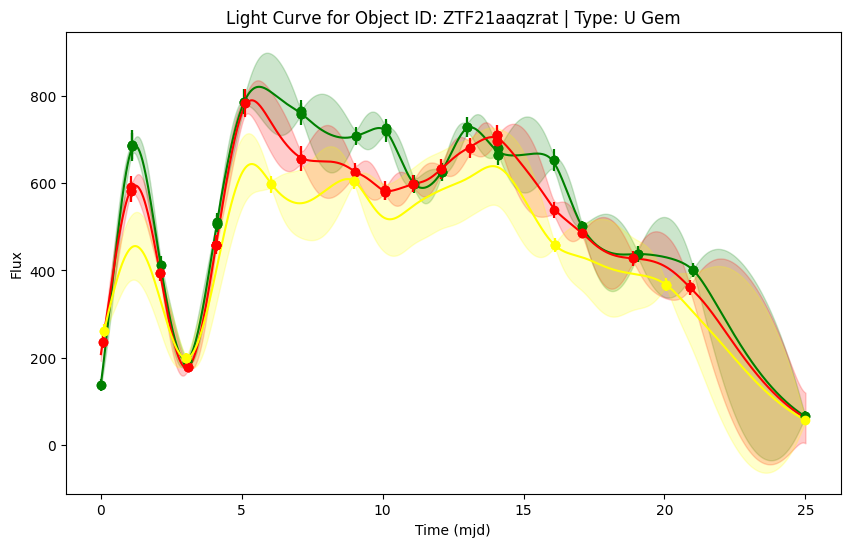

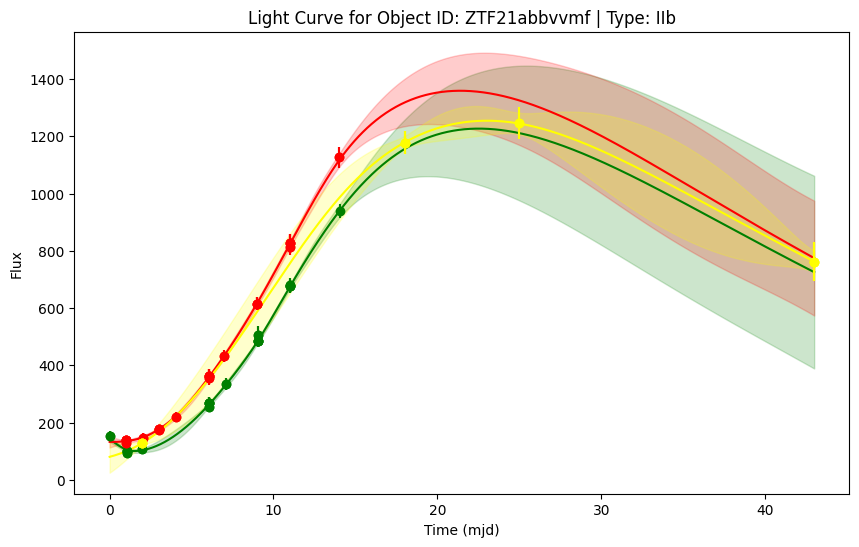

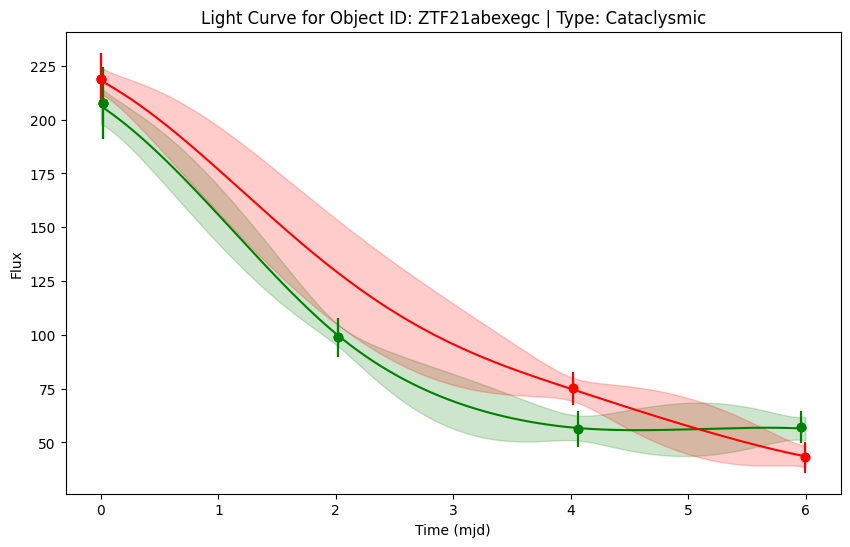

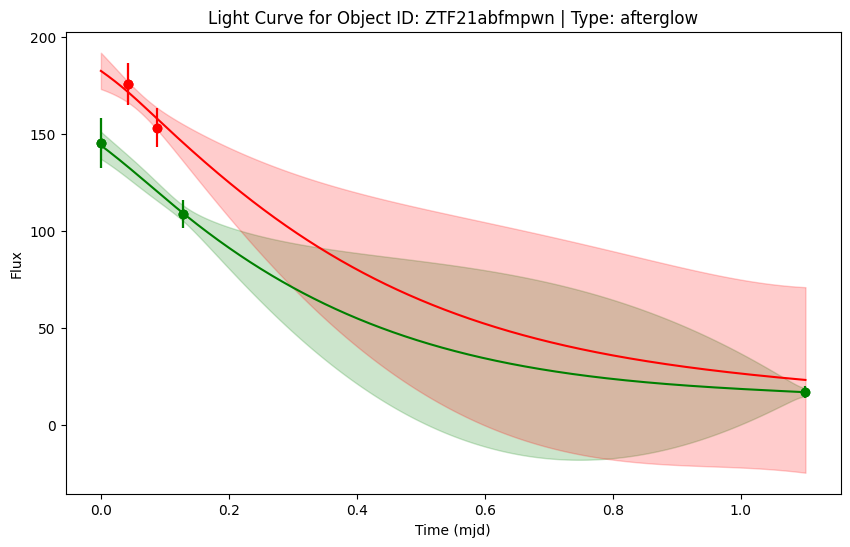

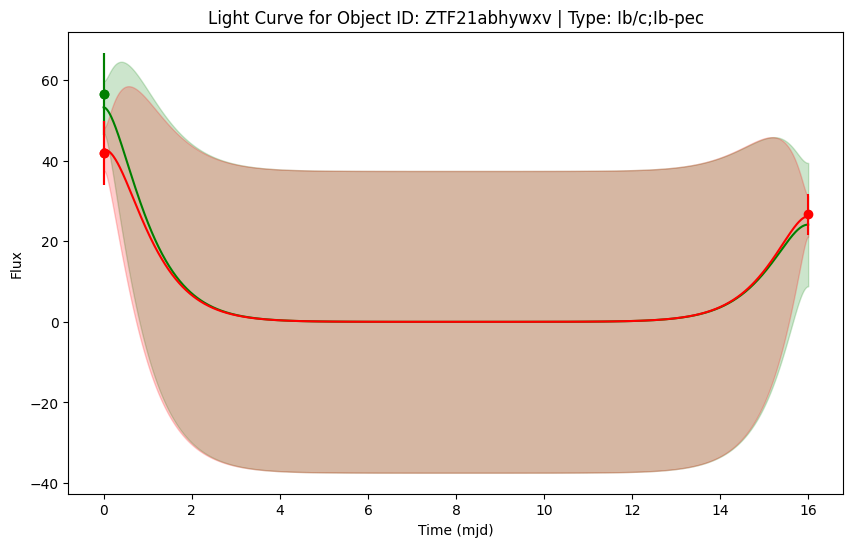

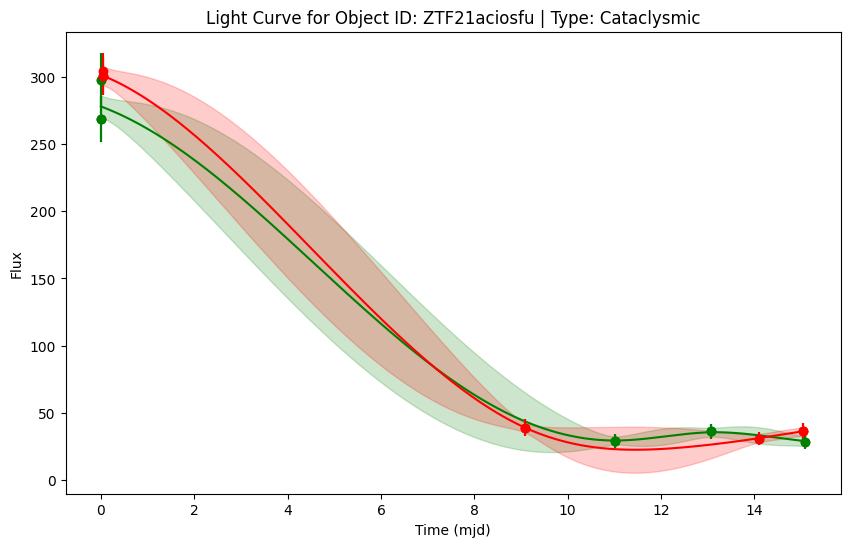

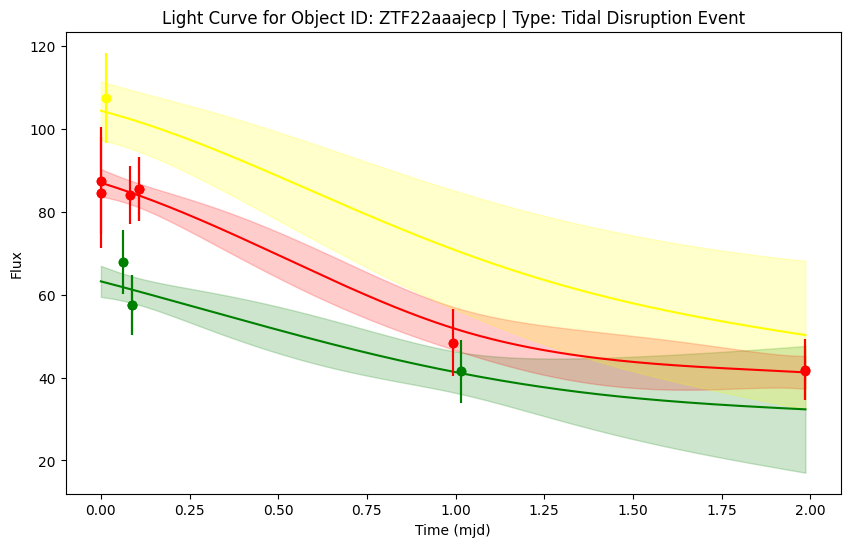

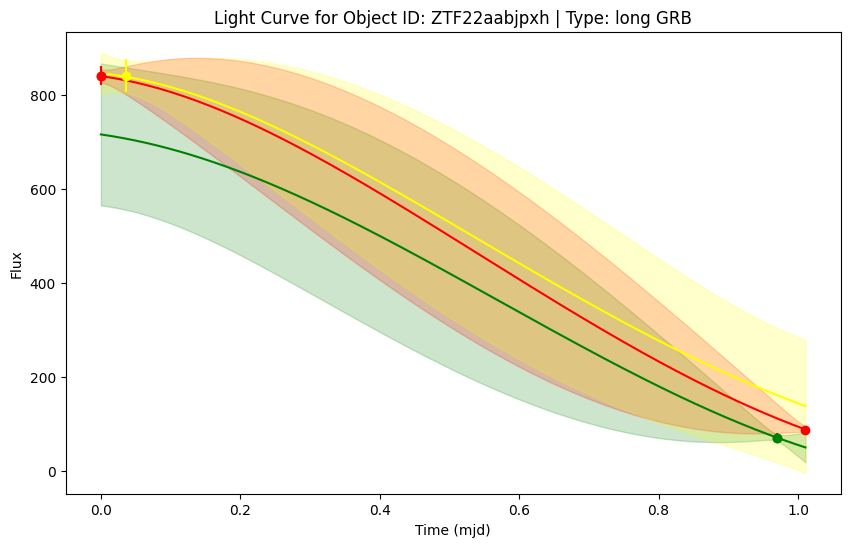

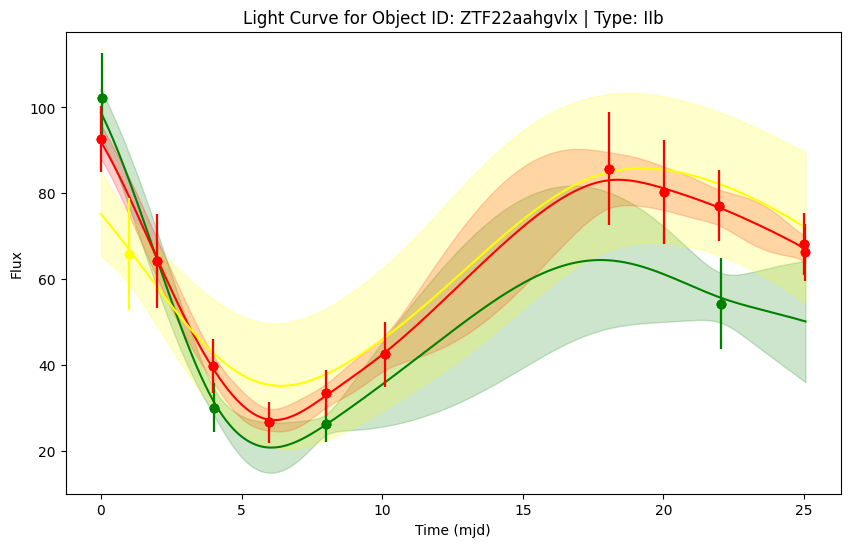

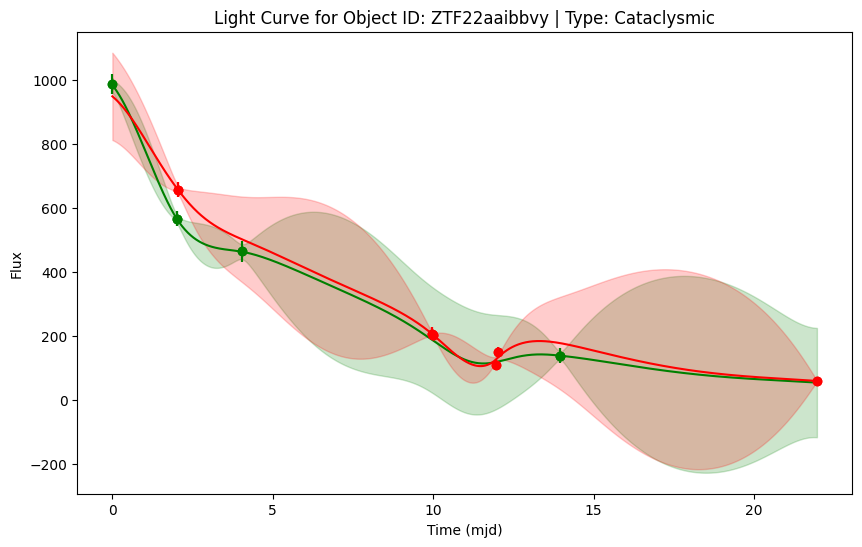

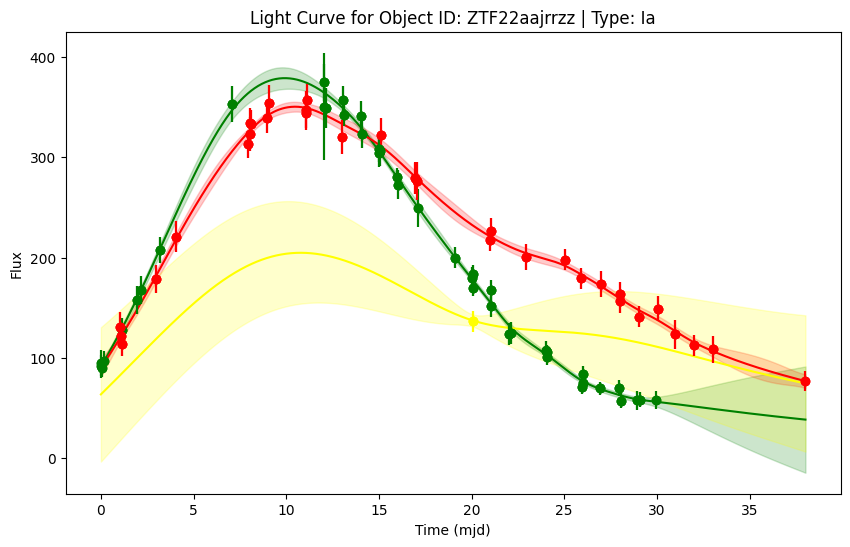

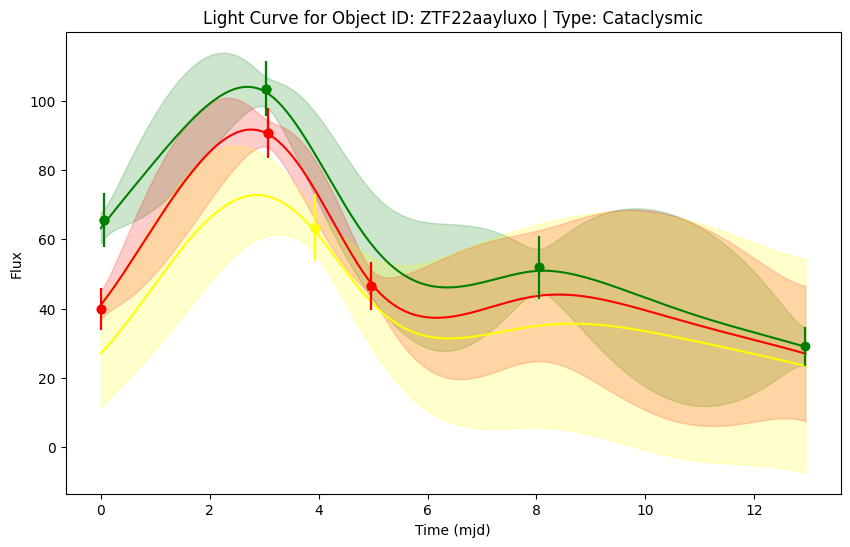

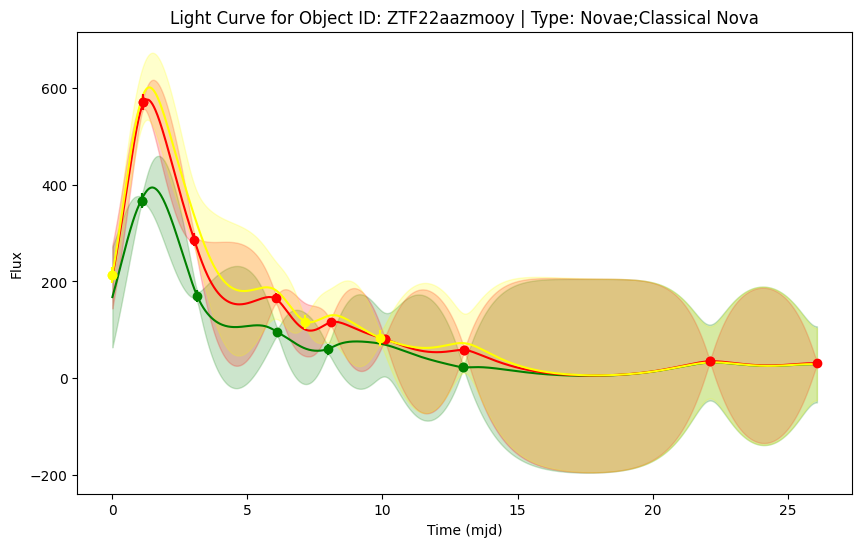

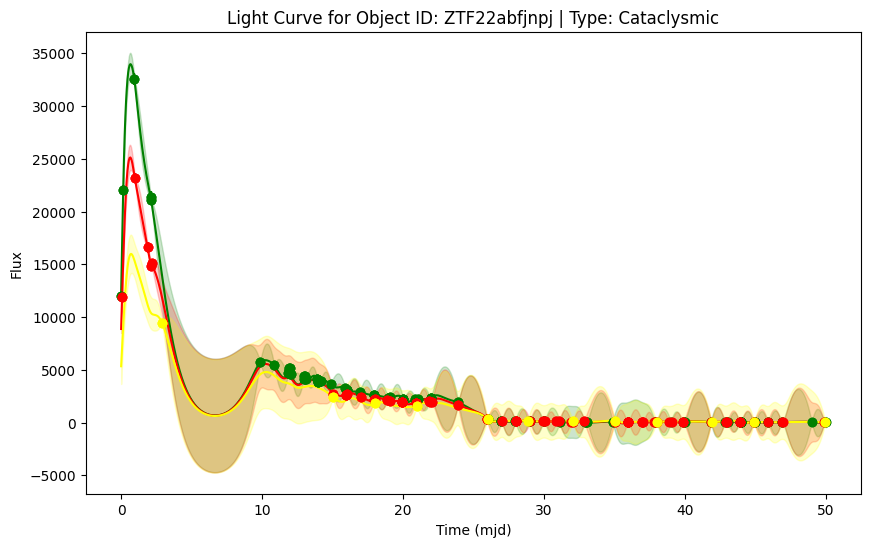

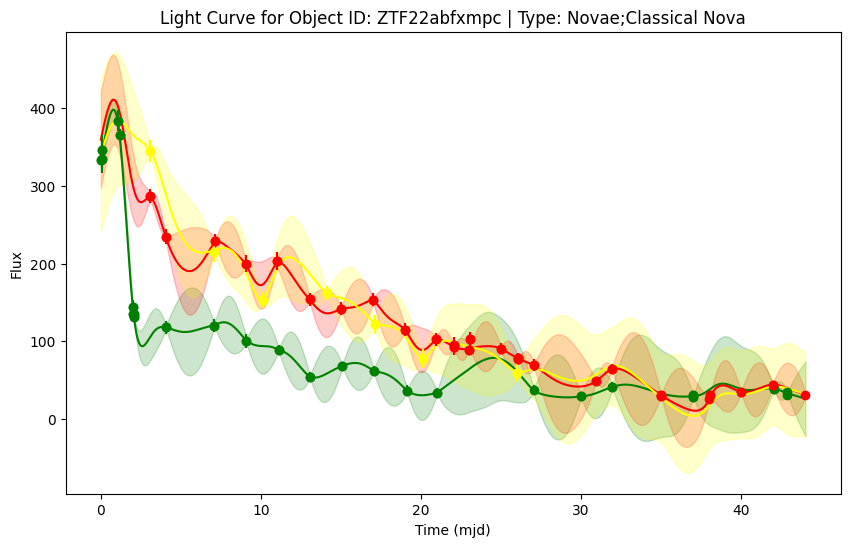

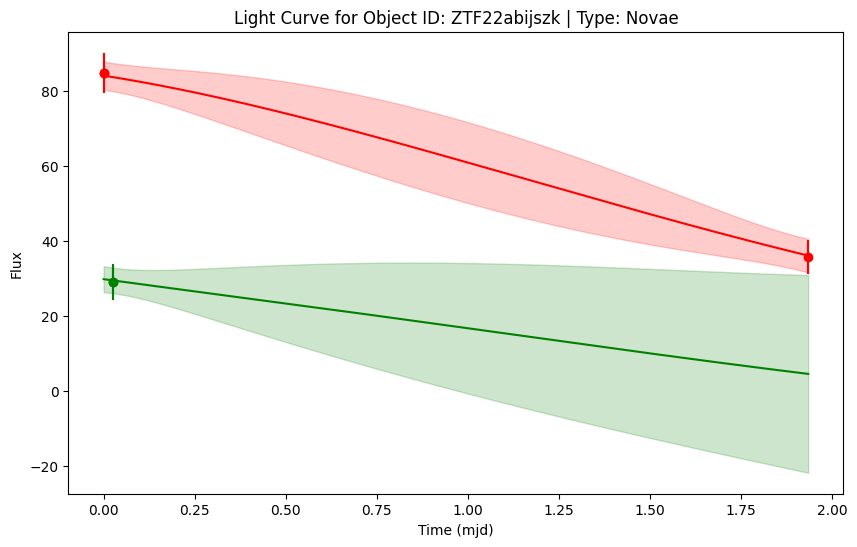

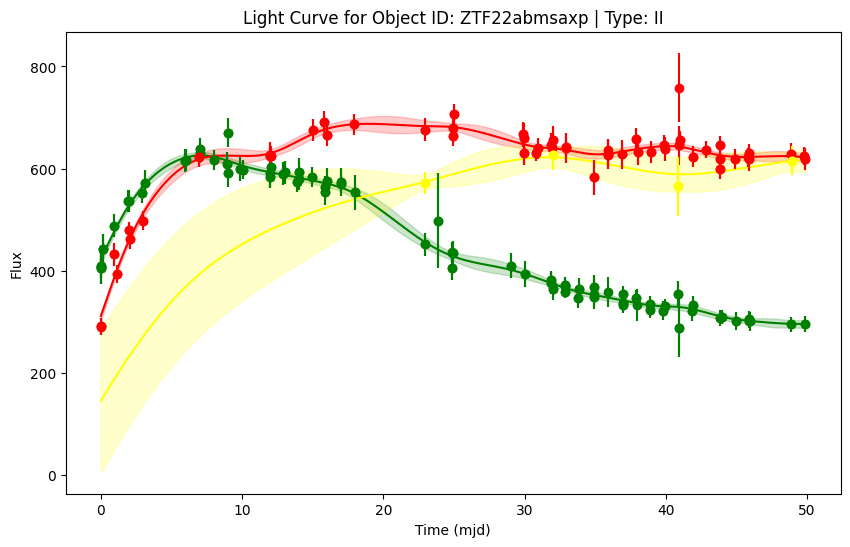

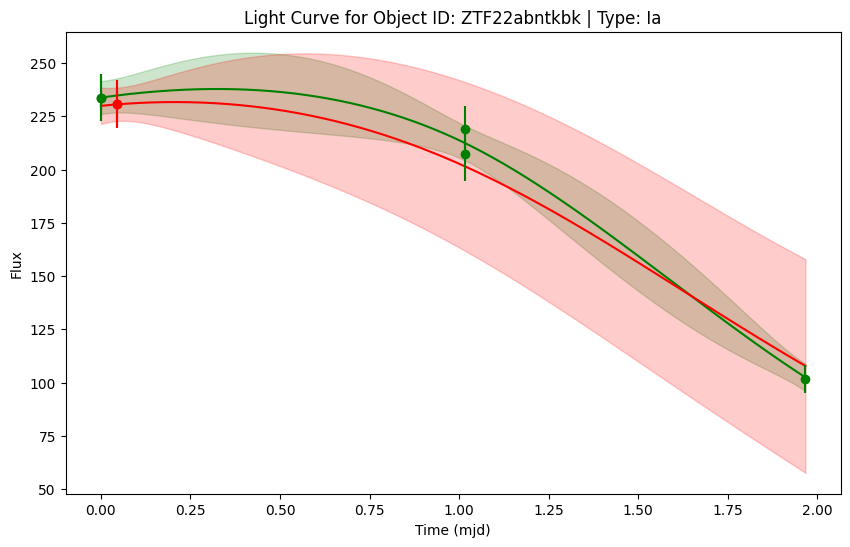

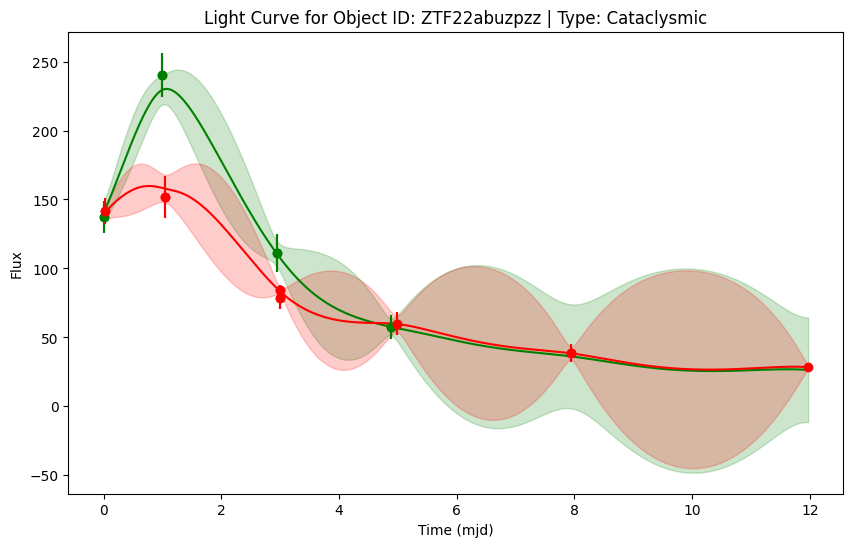

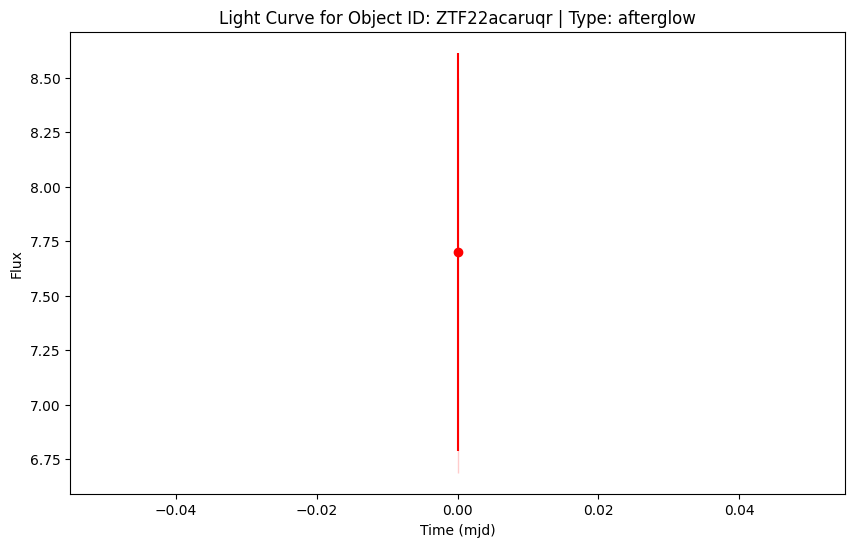

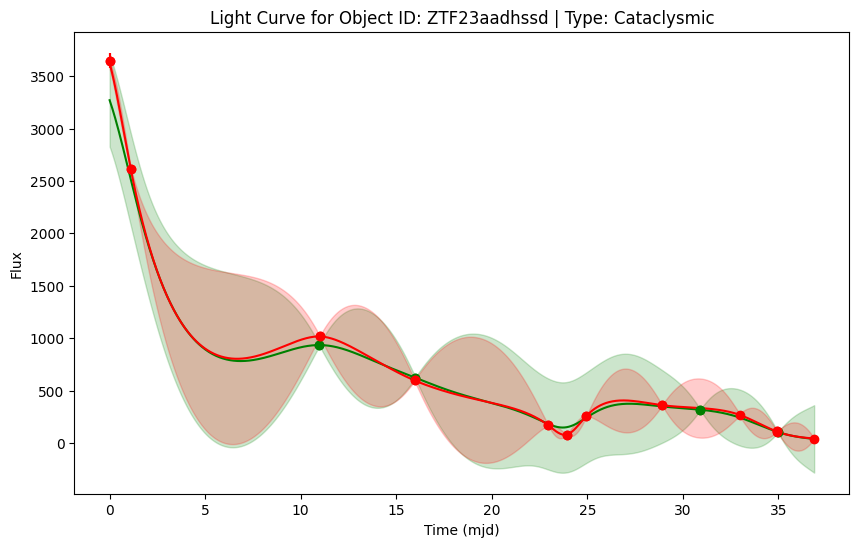

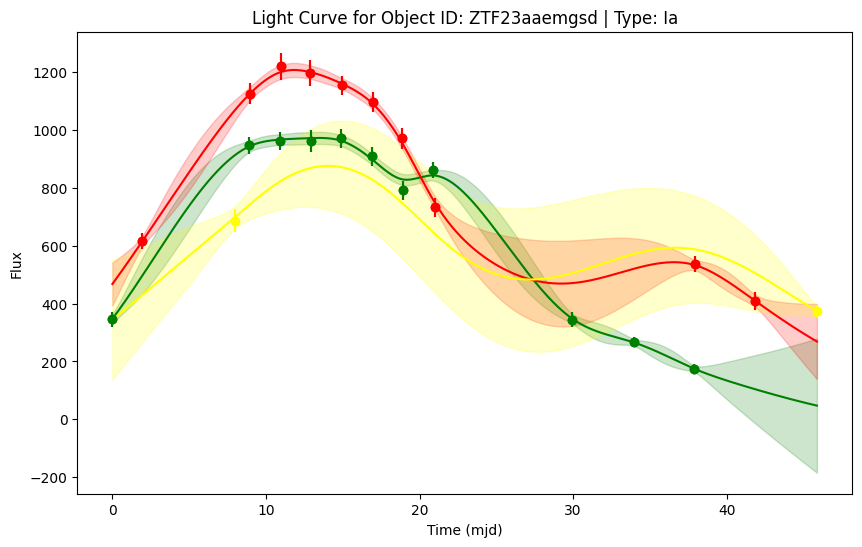

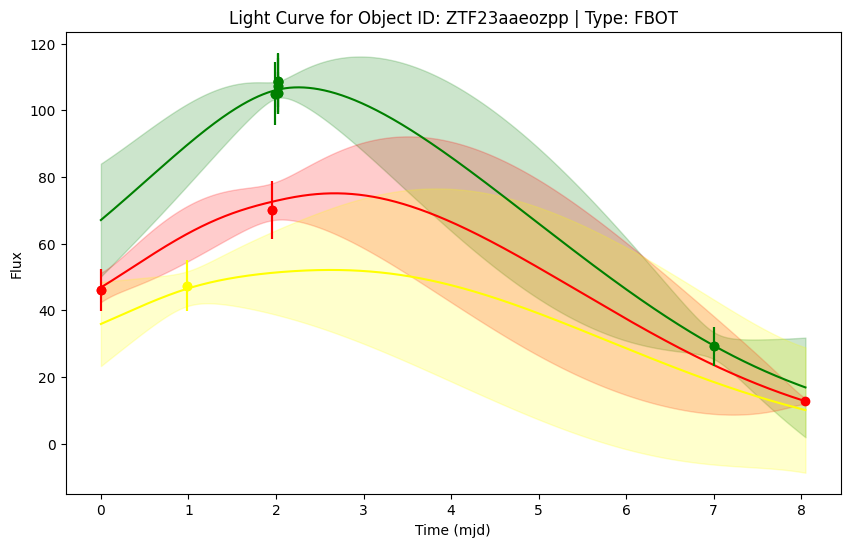

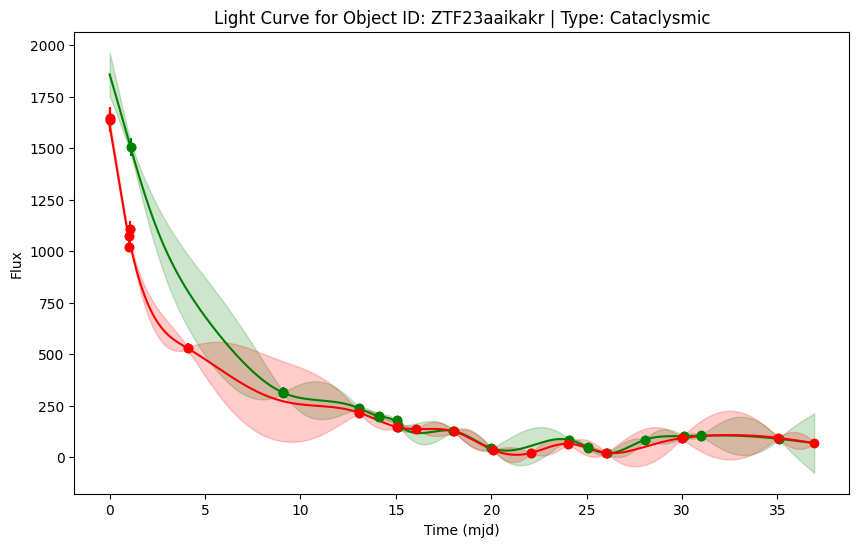

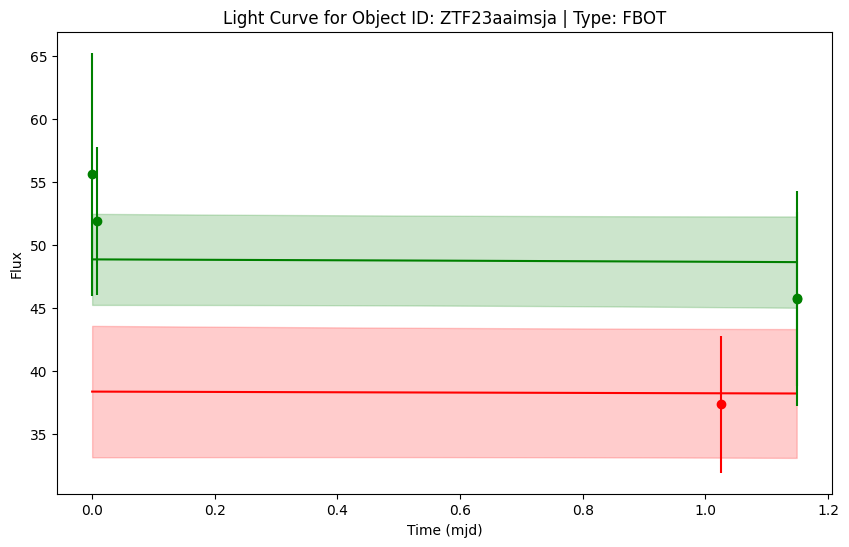

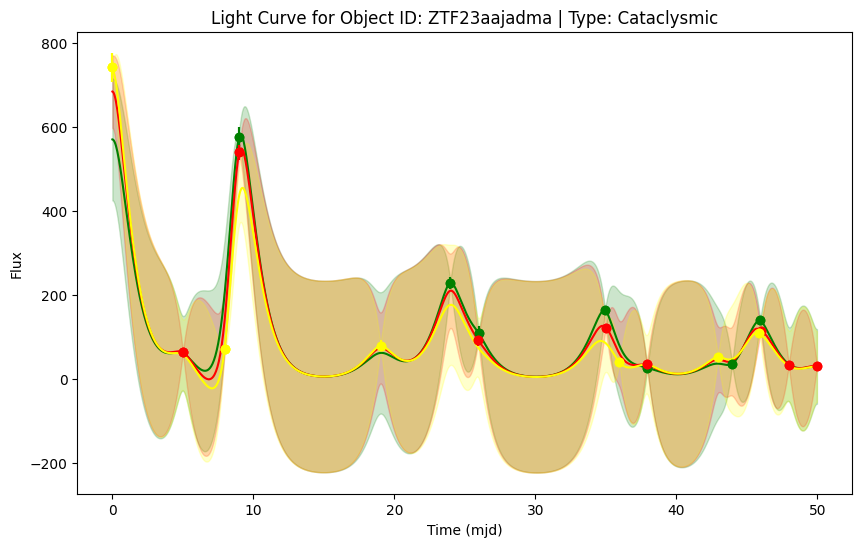

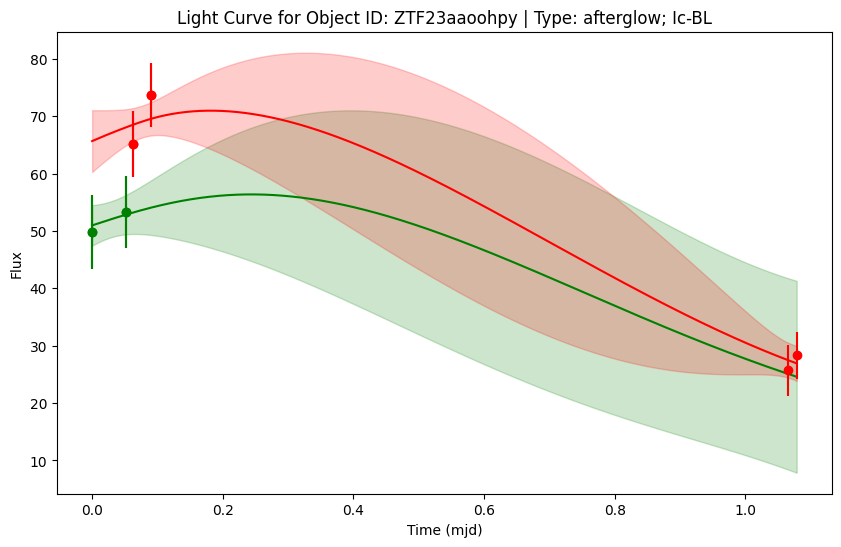

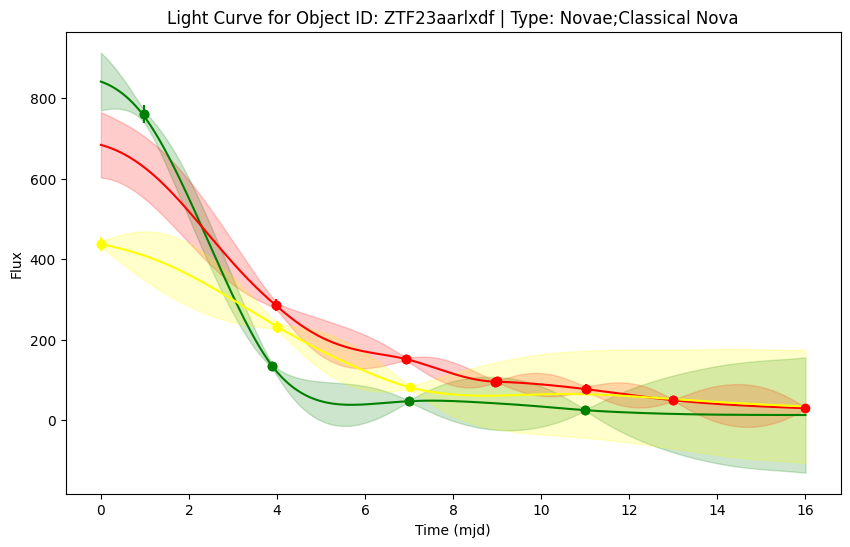

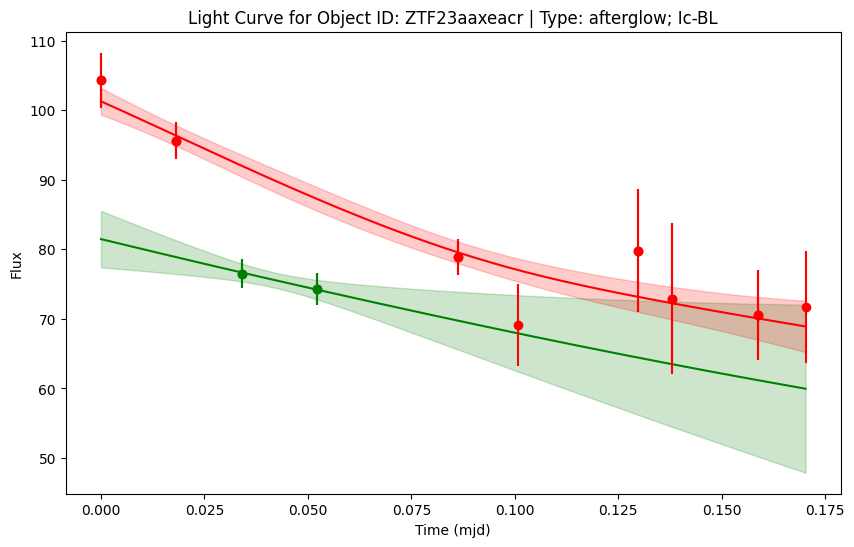

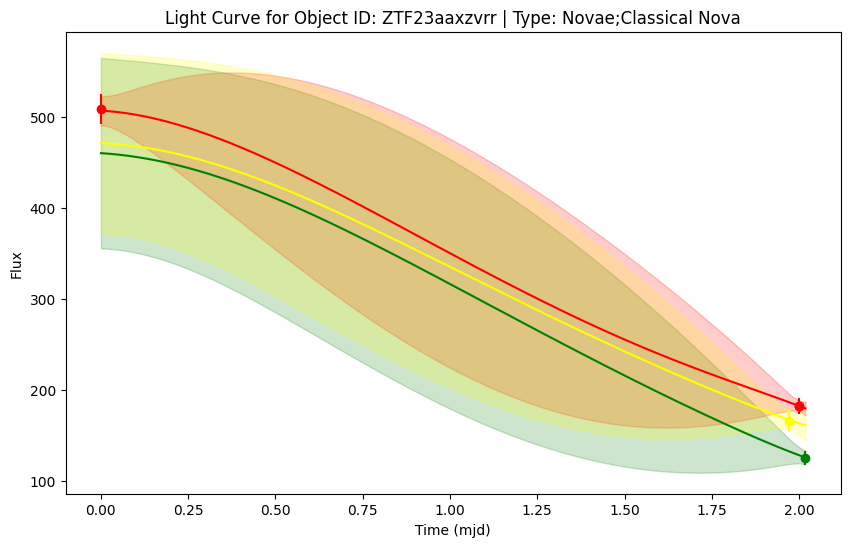

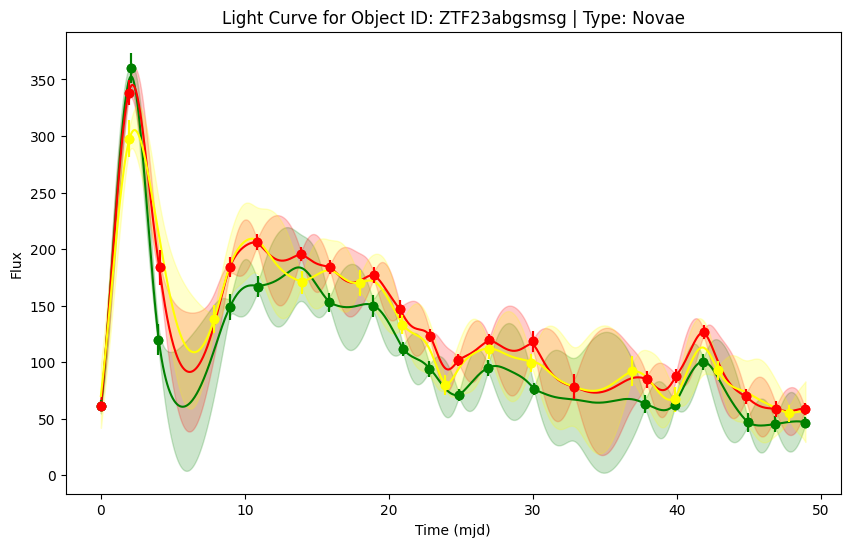

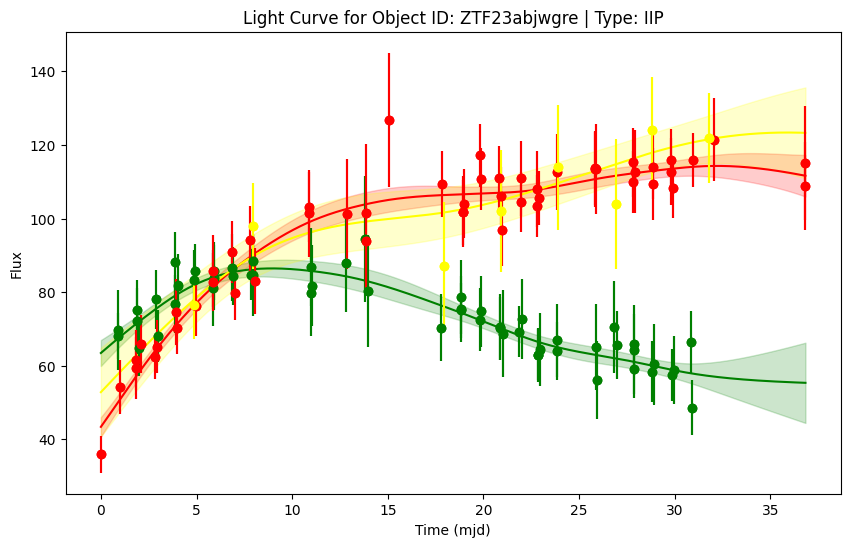

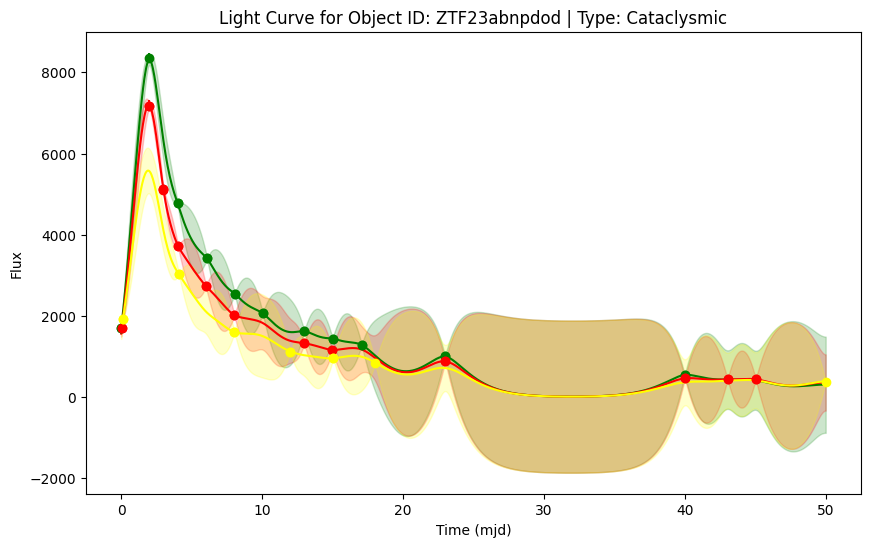

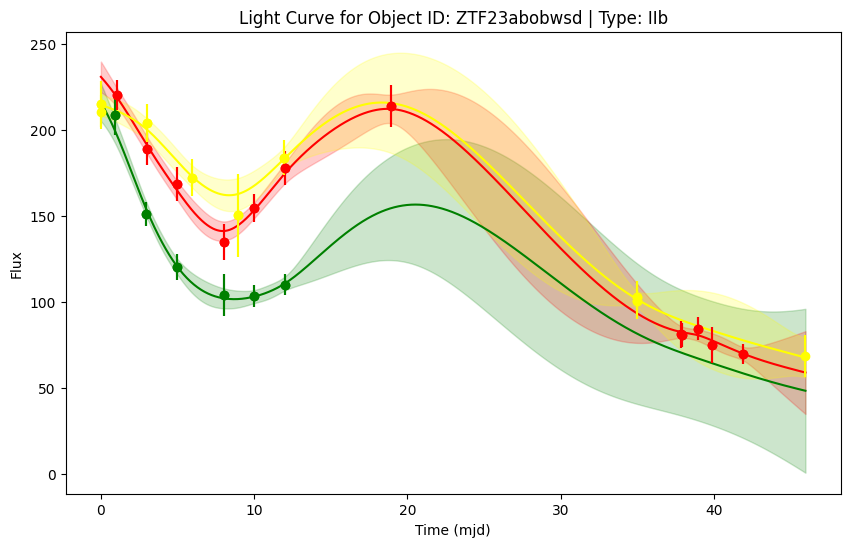

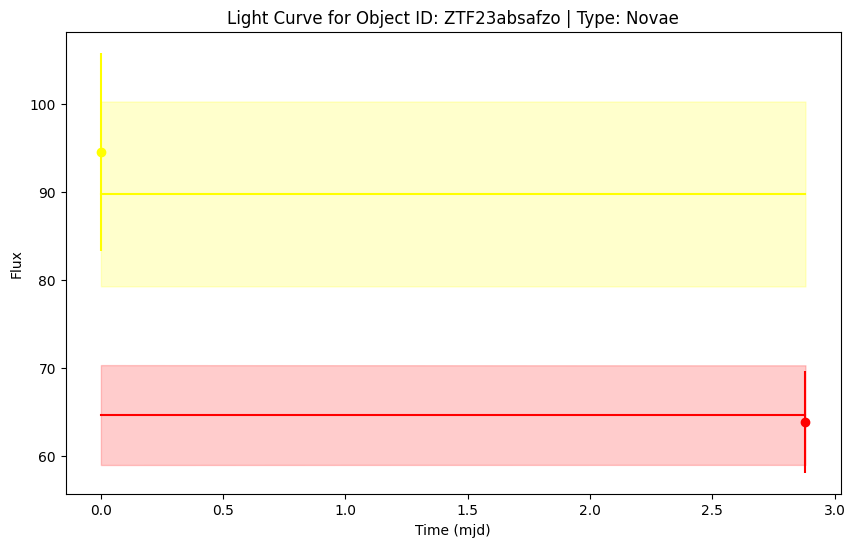

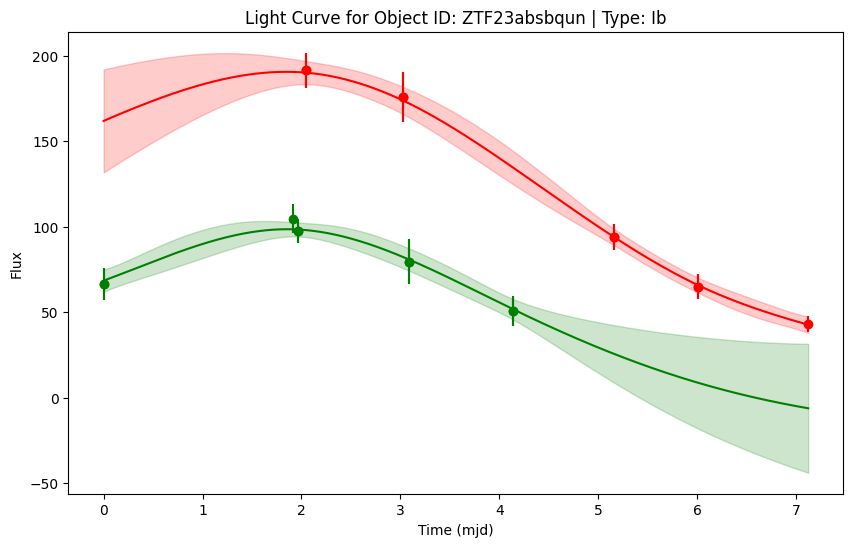

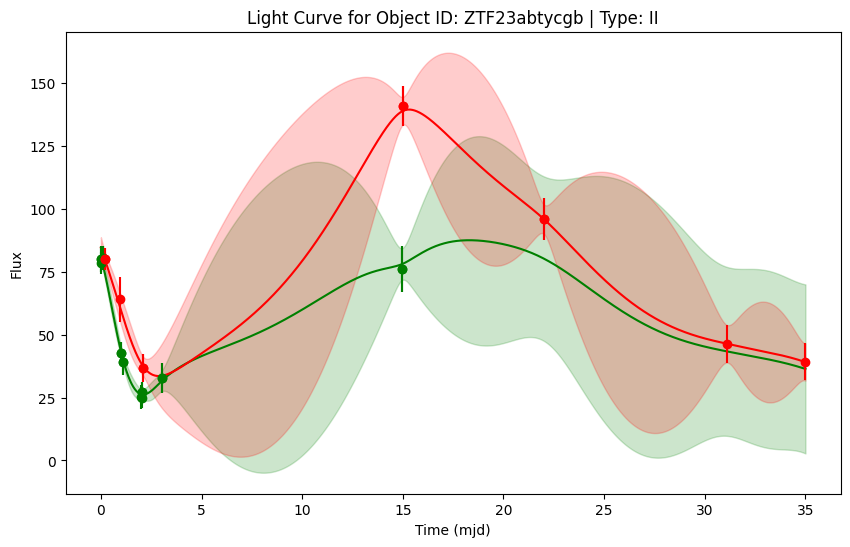

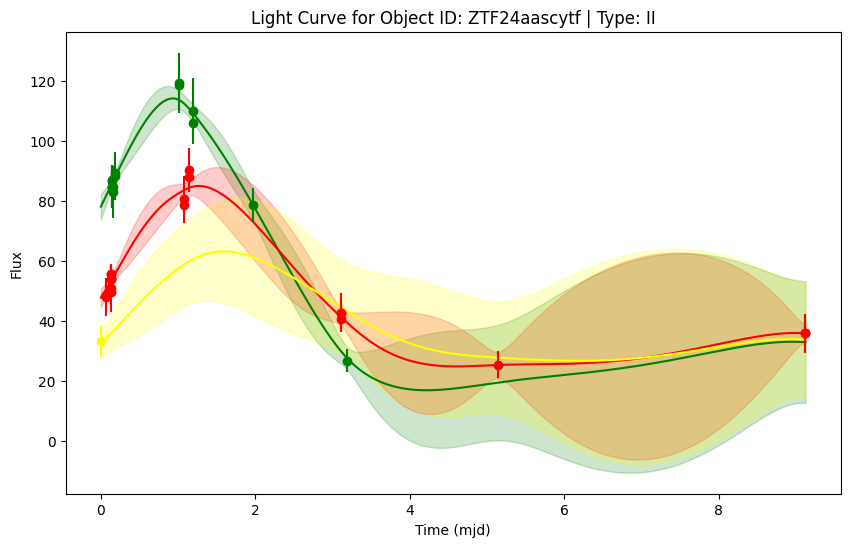

In [47]:
plot_results = total_results
obj_ids = plot_results['obj_id'].unique()
broken_obj_ids = []
for obj in obj_ids:
    one_df = plot_results[plot_results['obj_id'] == obj]
    two_df = norm_df[norm_df['obj_id']==obj]
    two_df = two_df[two_df['mjd']<50]
    fi, axi = plot_gp(one_df, show_legend=False)
    for filter_name in ['ztfg', 'ztfr', 'ztfi']:
        axi.errorbar(two_df[two_df['filter']==filter_name]['mjd'], two_df[two_df['filter']==filter_name]['flux'], yerr=two_df[two_df['filter']==filter_name]['flux_error'], fmt='o', label=f'Observed {filter_name}', color=color_dict[filter_name])
    plt.show()

In [22]:
# question_objects = ['ZTF19abacxod', 'ZTF19abxjrge', 'ZTF21aaabrpu', 'ZTF21aaabwfu', 'ZTF21aabxjqr', 'ZTF21aapkbav', 'ZTF21aaqzrat', 'ZTF23aajadma', 'ZTF23abtycgb']
# for obj in question_objects:
#     one_df = plot_results[plot_results['obj_id'] == obj]
#     two_df = norm_df[norm_df['obj_id']==obj]
#     two_df = two_df[two_df['mjd']<50]
#     fi, axi = plot_gp(one_df, show_legend=False)
#     for filter_name in ['ztfg', 'ztfr', 'ztfi']:
#         axi.errorbar(two_df[two_df['filter']==filter_name]['mjd'], two_df[two_df['filter']==filter_name]['flux'], yerr=two_df[two_df['filter']==filter_name]['flux_error'], fmt='o', label=f'Observed {filter_name}', color=color_dict[filter_name])
#     plt.show()

In [23]:
total_results

mjd   flux_ztfg   flux_ztfr  flux_error_ztfg  flux_error_ztfr type  \
0     0.000000  136.476566   99.008275        20.225414         1.245730  Ibn   
1     0.504350  162.972272  126.219481        16.229688         2.778614  Ibn   
2     1.008700  190.825310  153.363912        12.014731         3.524496  Ibn   
3     1.513051  219.423324  180.399970         7.692804         4.826813  Ibn   
4     2.017401  248.089537  206.392050         4.061100         5.478884  Ibn   
...        ...         ...         ...              ...              ...  ...   
7196  8.754780   32.991076   35.778804        22.383172        12.391853   II   
7197  8.846936   33.120805   35.975863        21.500098         9.773389   II   
7198  8.939092   33.177963   36.087816        20.818900         7.085820   II   
7199  9.031247   33.157022   36.099820        20.391462         4.547957   II   
7200  9.123403   33.054302   35.995481        20.256452         3.185979   II   

            obj_id         mjd_0 redshift  flux_ztfi  flux_error_ztfi  
0     ZTF18aakuewf  58226.340532   0.0636        NaN              NaN  
1     ZTF18aakuewf  58226.340532   0.0636        NaN              NaN  
2     ZTF18aakuewf  58226.340532   0.0636        NaN              NaN  
3     ZTF18aakuewf  58226.340532   0.0636        NaN              NaN  
4     ZTF18aakuewf  58226.340532   0.0636        NaN              NaN  
...            ...           ...      ...        ...              ...  
7196  ZTF24aascytf  60476.217836    0.038  33.941007        21.548910  
7197  ZTF24aascytf  60476.217836    0.038  34.034440        20.594324  
7198  ZTF24aascytf  60476.217836    0.038  34.056312        19.852856  
7199  ZTF24aascytf  60476.217836    0.038  34.000498        19.384630  
7200  ZTF24aascytf  60476.217836    0.038  33.862840        19.235181  

[7201 rows x 11 columns]

In [24]:
sorted(total_results['obj_id'].unique())

['ZTF18aakuewf',
 'ZTF18aalrxas',
 'ZTF18abffyqp',
 'ZTF18abvkmgw',
 'ZTF18abwkrbl',
 'ZTF19aanbpus',
 'ZTF19aapfmki',
 'ZTF19aatesgp',
 'ZTF19abacxod',
 'ZTF19abxjrge',
 'ZTF19abxtcio',
 'ZTF19abyjzvd',
 'ZTF19acbumks',
 'ZTF19accjfgv',
 'ZTF20aahfqpm',
 'ZTF20aajnksq',
 'ZTF20aaxhzhc',
 'ZTF20aayrobw',
 'ZTF20aazchcq',
 'ZTF20abstsxb',
 'ZTF20aburywx',
 'ZTF20abwysqy',
 'ZTF20abwzqzo',
 'ZTF20acgigfo',
 'ZTF20acgiglu',
 'ZTF20acigusw',
 'ZTF20aclfmwn',
 'ZTF20acozryr',
 'ZTF20acqntkr',
 'ZTF20actqnhg',
 'ZTF21aaabrpu',
 'ZTF21aaabwfu',
 'ZTF21aabxjqr',
 'ZTF21aagwbjr',
 'ZTF21aapkbav',
 'ZTF21aaqzrat',
 'ZTF21abbvvmf',
 'ZTF21abexegc',
 'ZTF21abfmpwn',
 'ZTF21abhywxv',
 'ZTF21aciosfu',
 'ZTF22aaajecp',
 'ZTF22aabjpxh',
 'ZTF22aahgvlx',
 'ZTF22aaibbvy',
 'ZTF22aajrrzz',
 'ZTF22aayluxo',
 'ZTF22aazmooy',
 'ZTF22abfjnpj',
 'ZTF22abfxmpc',
 'ZTF22abijszk',
 'ZTF22abmsaxp',
 'ZTF22abntkbk',
 'ZTF22abuzpzz',
 'ZTF22acaruqr',
 'ZTF23aadhssd',
 'ZTF23aaemgsd',
 'ZTF23aaeozpp',
 'ZTF23aaikakr

In [40]:
from astropy.coordinates import Distance
import astropy.units as u
def absmag(m, z):
    '''
    Converts apparent magnitude to absolute magnitude.
    
    Args:
        m (float): apparent magnitude
        z (float): redshift
    '''
    try:
        z = float(z)
    except ValueError:
        if type(z) == str:
            z = float(z.split('±')[0])
    if m is None or m is np.nan or z is None or z is np.nan:
        return np.nan
    else:
        if z==0:
            M = m
        elif z < 0:
            M = m
        else:
            try:
                d = Distance(unit=u.pc, z=float(z), allow_negative=True)
                M = m - 5 * np.log10(d/(10*u.pc)) + 5
            except:
                M = np.nan
        return M
absmag = np.vectorize(absmag)

def Norm2Mag(df):
    df_copy = df.copy()
    for filter in ['ztfg', 'ztfr', 'ztfi']:
        df_copy[f'mag_{filter}'] = 23.9 - 2.5 * np.log10(df_copy[f'flux_{filter}'])
        df_copy[f'abs_mag_{filter}'] = [absmag(m, z) for m, z in zip(df_copy[f'mag_{filter}'], df_copy['redshift'])]
        df_copy[f'mag_error_{filter}'] = 2.5 * df_copy[f'flux_error_{filter}'] / (df_copy[f'flux_{filter}'] * np.log(10))
    df_copy['t'] = df_copy['mjd']
    df_copy['mjd'] = df_copy['mjd'] + df_copy['mjd_0']
    # df_copy.reset_index(drop=True, inplace=True)
    return df_copy  

In [48]:
total_mag = Norm2Mag(total_results)
# total_mag[total_mag['obj_id'] == 'ZTF18aakuewf']
display(total_mag)

/home/tbarna/anaconda3/envs/nmma_env/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/tbarna/anaconda3/envs/nmma_env/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/tbarna/anaconda3/envs/nmma_env/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


mjd   flux_ztfg   flux_ztfr  flux_error_ztfg  flux_error_ztfr  \
0      58226.340532  136.473151   99.008321        20.223566         1.245737   
1      58226.390513  139.022248  101.683596        19.834904         1.079511   
2      58226.440494  141.589596  104.383825        19.445064         1.085820   
3      58226.490474  144.174698  107.090648        19.053877         1.235566   
4      58226.540455  146.777048  109.794837        18.661182         1.460953   
...             ...         ...         ...              ...              ...   
71996  60485.304708   33.104947   36.051876        20.273348         3.441576   
71997  60485.313841   33.093513   36.039692        20.264562         3.332267   
71998  60485.322973   33.081261   36.026243        20.258811         3.251571   
71999  60485.332106   33.068191   36.011512        20.256105         3.202154   
72000  60485.341238   33.054302   35.995481        20.256452         3.185979   

      type        obj_id         mjd_0 redshift  flux_ztfi  ...   mag_ztfg  \
0      Ibn  ZTF18aakuewf  58226.340532   0.0636        NaN  ...  18.562382   
1      Ibn  ZTF18aakuewf  58226.340532   0.0636        NaN  ...  18.542289   
2      Ibn  ZTF18aakuewf  58226.340532   0.0636        NaN  ...  18.522422   
3      Ibn  ZTF18aakuewf  58226.340532   0.0636        NaN  ...  18.502777   
4      Ibn  ZTF18aakuewf  58226.340532   0.0636        NaN  ...  18.483355   
...    ...           ...           ...      ...        ...  ...        ...   
71996   II  ZTF24aascytf  60476.217836    0.038  33.927364  ...  20.100268   
71997   II  ZTF24aascytf  60476.217836    0.038  33.912465  ...  20.100643   
71998   II  ZTF24aascytf  60476.217836    0.038  33.896745  ...  20.101045   
71999   II  ZTF24aascytf  60476.217836    0.038  33.880203  ...  20.101474   
72000   II  ZTF24aascytf  60476.217836    0.038  33.862840  ...  20.101930   

              abs_mag_ztfg mag_error_ztfg   mag_ztfr         abs_mag_ztfr  \
0      -13.788383626551152       0.160892  18.910821  -13.439944818486431   
1      -13.808476352265565       0.154907  18.881873  -13.468892821415523   
2      -13.828343937666467       0.149108  18.853417  -13.497348594027748   
3      -13.847988208456908       0.143489  18.825621  -13.525144446607108   
4      -13.867410954101864       0.138040  18.798545  -13.552220378245792   
...                    ...            ...        ...                  ...   
71996  -11.092596283949472       0.664901  20.007680  -11.185183712672938   
71997  -11.092221197800153       0.664842  20.008047  -11.184816701076876   
71998  -11.091819159172488       0.664900  20.008453  -11.184411469292467   
71999  -11.091390112998212       0.665074  20.008897  -11.183967431121992   
72000   -11.09093401008688       0.665365  20.009380  -11.183483990037878   

      mag_error_ztfr   mag_ztfi         abs_mag_ztfi mag_error_ztfi         t  
0           0.013661        NaN                  nan            NaN  0.000000  
1           0.011527        NaN                  nan            NaN  0.049981  
2           0.011294        NaN                  nan            NaN  0.099961  
3           0.012527        NaN                  nan            NaN  0.149942  
4           0.014447        NaN                  nan            NaN  0.199923  
...              ...        ...                  ...            ...       ...  
71996       0.103646  20.073625  -11.119239346242075       0.616174  9.086873  
71997       0.100388  20.074102  -11.118762418529709       0.616131  9.096005  
71998       0.097994  20.074605  -11.118259010506257       0.616210  9.105138  
71999       0.096544  20.075135  -11.117729054369473       0.616410  9.114270  
72000       0.096099  20.075692   -11.11717248882702       0.616733  9.123403  

[72001 rows x 21 columns]

In [49]:
# total_mag.to_csv('gp_objects.csv', index=False)